## Importing Libraries

In [72]:
'''
    The original Transformer code is from: http://nlp.seas.harvard.edu/2018/04/03/attention.html
'''

import os,sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib
from lifelines import *
import pandas as pd
import  argparse
from operator import itemgetter
from concordance import concordance_index

from types import SimpleNamespace

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# parser = argparse.ArgumentParser(description='Survival analysis')
# parser.add_argument('--max_time', type=int, default=500, help='Max number of months')
# parser.add_argument('--num_epochs', type=int, default=200)
# parser.add_argument('--N', type=int, default=6, help='Number of modules')
# parser.add_argument('--num_heads', type=int, default=8)
# parser.add_argument('--d_model', type=int, default=64)
# parser.add_argument('--d_ff', type=int, default=256)
# parser.add_argument('--train_batch_size', type=int, default=16)
# parser.add_argument('--drop_prob', type=float, default=0.1)
# parser.add_argument('--lr', type=float, default=0.0001)
# parser.add_argument('--coeff', type=float, default=1.0)
# parser.add_argument('--coeff2', type=float, default=1.0)
# parser.add_argument('--data_dir', type=str, default='data/split1')
# parser.add_argument('--save_ckpt_dir', type=str, default='checkpoints')
# parser.add_argument('--report_interval', type=int, default=5)
# parser.add_argument('--data_parallel', action='store_true', help='use data parallel?')
# parser.add_argument('--pred_method', type=str, choices=['mean', 'median'], default='mean')
# opt = parser.parse_args()


# Define hyperparameters as a dictionary
opt = {
    'max_time': 500,  
    'num_epochs': 200,
    'N': 6,  
    'num_heads': 8,
    'd_model': 64,
    'd_ff': 256,
    'train_batch_size': 16,
    'drop_prob': 0.1,
    'lr': 0.0001,
    'coeff': 1.0,
    'coeff2': 1.0,
    'data_dir': 'data/',  # Adjust path as needed
    'save_ckpt_dir': 'checkpoints',
    'report_interval': 5,
    'data_parallel': False,  # Set True if using multiple GPUs
    'pred_method': 'mean'  # Options: 'mean' or 'median'
}

print(opt)
opt = SimpleNamespace(**opt)

# Create the checkpoint directory
if not os.path.exists(opt.save_ckpt_dir):
    os.makedirs(opt.save_ckpt_dir)

class TranDataset(Dataset):
    def __init__(self, features, labels, is_train=True):
        self.is_train = is_train
        self.data = []

        temp = []
        for feature, label in zip(features, labels):
            feature = torch.from_numpy(feature).float()
            duration, is_observed = label[0], label[1]
            temp.append([duration, is_observed, feature])
        sorted_temp = sorted(temp, key=itemgetter(0))

        if self.is_train:
            new_temp = sorted_temp
        else:
            new_temp = temp

        for duration, is_observed, feature in new_temp:
            if is_observed:
                mask = opt.max_time * [1.]
                label = duration * [1.] + (opt.max_time - duration) * [0.]
                feature = torch.stack(opt.max_time * [feature])
                self.data.append([feature.to(device), torch.tensor(duration).float().to(device), torch.tensor(mask).float().to(device), torch.tensor(label).to(device), torch.tensor(is_observed).byte().to(device)])
            else:
                # NOTE plus 1 to include day 0
                mask = (duration + 1) * [1.] + (opt.max_time - (duration + 1)) * [0.]
                label = opt.max_time * [1.]
                feature = torch.stack(opt.max_time * [feature])
                self.data.append([feature.to(device), torch.tensor(duration).float().to(device), torch.tensor(mask).float().to(device), torch.tensor(label).to(device), torch.tensor(is_observed).byte().to(device)])

    def __getitem__(self, index_a):
        if self.is_train:
            if index_a == len(self.data) - 1:
                index_b = np.random.randint(len(self.data))
            else:
                # NOTE self.data is sorted
                index_b = np.random.randint(index_a+1, len(self.data))
            return [ [self.data[index_a][i], self.data[index_b][i]] for i in range(len(self.data[index_a])) ]
        else:
            return self.data[index_a]

    def __len__(self):
        return len(self.data)


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -torch.tensor(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))


# Initial embedding for raw input
class SrcEmbed(nn.Module):
    def __init__(self, input_dim, d_model):
        super(SrcEmbed, self).__init__()
        self.w = nn.Linear(input_dim, d_model)
        self.norm = LayerNorm(d_model)

    def forward(self, x):
        return self.norm(self.w(x))


# Final layer for the Transformer
class TranFinalLayer(nn.Module):
    def __init__(self, d_model):
        super(TranFinalLayer, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model // 2)
        self.norm = LayerNorm(d_model // 2)
        self.w_2 = nn.Linear(d_model // 2, 1)

    def forward(self, x):
        x = F.relu(self.w_1(x))
        x = self.norm(x)
        x = self.w_2(x)
        return torch.sigmoid(x.squeeze(-1))


class Encoder(nn.Module):
    def __init__(self, layer, N, d_model, dropout, num_features):
        super(Encoder, self).__init__()
        self.src_embed = SrcEmbed(num_features, d_model)
        self.position_encode = PositionalEncoding(d_model, dropout)
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        self.final_layer = TranFinalLayer(d_model)
        
    def forward(self, x, mask=None):
        x = self.position_encode(self.src_embed(x))
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_layer(x)


class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


def evaluate(encoder, test_loader):
    encoder.eval()
    with torch.no_grad():
        pred_durations, true_durations, is_observed = [], [], []
        pred_obs_durations, true_obs_durations = [], []

        total_surv_probs = []

        # NOTE batch size is 1
        for features, durations, mask, label, is_observed_single in test_loader:
            is_observed.append(is_observed_single)
            sigmoid_preds = encoder.forward(features)
            surv_probs = torch.cumprod(sigmoid_preds, dim=1).squeeze()
            total_surv_probs.append(surv_probs)

            if opt.pred_method == 'mean':
                pred_duration = torch.sum(surv_probs).item()
            elif opt.pred_method == 'median':
                pred_duration = 0
                while True:
                    if surv_probs[pred_duration] < 0.5:
                        break
                    else:
                        pred_duration += 1
                        if pred_duration == len(surv_probs):
                            break

            true_duration = durations.squeeze().item()
            pred_durations.append(pred_duration)
            true_durations.append(true_duration)

            if is_observed_single:
                pred_obs_durations.append(pred_duration)
                true_obs_durations.append(true_duration)

        total_surv_probs = torch.stack(total_surv_probs)

        pred_obs_durations = np.asarray(pred_obs_durations)
        true_obs_durations = np.asarray(true_obs_durations)
        mae_obs = np.mean(np.abs(pred_obs_durations - true_obs_durations))

        pred_durations = np.asarray(pred_durations)
        true_durations = np.asarray(true_durations)
        is_observed = np.asarray(is_observed, dtype=bool)

        print('pred durations OBS', pred_durations[is_observed].round())
        print('true durations OBS', true_durations[is_observed].round())

        print('pred durations CRS', pred_durations[~is_observed].round())
        print('true durations CRS', true_durations[~is_observed].round())

        test_cindex = concordance_index(true_durations, pred_durations, is_observed)
        print('c index', test_cindex, 'mean abs error (OBS)', mae_obs)

    return test_cindex, mae_obs, total_surv_probs


def checkpoint(model, total_surv_probs):
    datadir = opt.data_dir.replace('/', '.')
    model_out_path = "{}/best_model_trainset_{}.pth".format(opt.save_ckpt_dir, datadir)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

    # Save npy array
    surv_probs_out_path = "{}/best_surv_probs_test_{}.pth".format(opt.save_ckpt_dir, datadir)
    np.save(surv_probs_out_path, total_surv_probs.cpu().numpy())


from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, durations, mask, labels, is_observed = zip(*batch)

    # Pad sequences to the max length within the batch
    features = pad_sequence(features, batch_first=True, padding_value=0)
    durations = pad_sequence(durations, batch_first=True, padding_value=0)

    return features, durations, mask, labels, is_observed

# train_loader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

def train(features, labels, encoder):

    train_loader = DataLoader(TranDataset(features[0], labels[0], is_train=True), batch_size=opt.train_batch_size, collate_fn=collate_fn, shuffle=True)
    # NOTE VAL batch size is 1
    val_loader = DataLoader(TranDataset(features[1], labels[1], is_train=False), batch_size=1, shuffle=False)
    # NOTE TEST batch size is 1
    test_loader = DataLoader(TranDataset(features[2], labels[2], is_train=False), batch_size=1, shuffle=False)
    # NOTE using C index as early stopping criterion
    best_val_cindex, best_test_cindex, best_test_mae, best_epoch = -1, -1, 9999999, 0

    optimizer = torch.optim.Adam(encoder.parameters(), lr=opt.lr)

    for t in range(opt.num_epochs):
        print('epoch', t)
        encoder.train()

        tot_loss = 0.
        for features, true_durations, mask, label, is_observed in train_loader:
            optimizer.zero_grad()

            is_observed_a = is_observed[0]
            mask_a = mask[0]
            mask_b = mask[1]
            label_a = label[0]
            label_b = label[1]
            true_durations_a = true_durations[0]
            true_durations_b = true_durations[1]

            sigmoid_a = encoder.forward(features[0])
            surv_probs_a = torch.cumprod(sigmoid_a, dim=1)
            loss = nn.BCELoss()(surv_probs_a * mask_a, label_a * mask_a)

            sigmoid_b = encoder.forward(features[1])
            surv_probs_b = torch.cumprod(sigmoid_b, dim=1)

            cond_a = is_observed_a & (true_durations_a < true_durations_b)
            if torch.sum(cond_a) > 0:
                mean_lifetimes_a = torch.sum(surv_probs_a, dim=1)
                mean_lifetimes_b = torch.sum(surv_probs_b, dim=1)
                diff = mean_lifetimes_b[cond_a] - mean_lifetimes_a[cond_a]
                true_diff = true_durations_b[cond_a] - true_durations_a[cond_a]
                loss += opt.coeff * torch.mean(nn.ReLU()(true_diff - diff))

            cond_a2 = is_observed_a
            if torch.sum(cond_a2) > 0:
                mean_lifetimes_a = torch.sum(surv_probs_a, dim=1)
                loss += opt.coeff2 * F.l1_loss(mean_lifetimes_a[cond_a2], true_durations_a[cond_a2])

            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
        print('train total loss', tot_loss)

        # Evaluate
        if t > 0 and t % opt.report_interval == 0:
            print('VAL')
            val_cindex, val_mae, val_total_surv_probs = evaluate(encoder, val_loader)
            print('TEST')
            test_cindex, test_mae, test_total_surv_probs = evaluate(encoder, test_loader)

            if val_cindex > best_val_cindex:
                best_val_cindex = val_cindex
                best_val_mae = val_mae
                best_test_cindex = test_cindex
                best_test_mae = test_mae
                best_epoch = t
                checkpoint(encoder, test_total_surv_probs)

            print('current val cindex', val_cindex, 'val mae', val_mae)
            print('BEST val cindex', best_val_cindex, 'mae', best_val_mae, 'at epoch', best_epoch)
            print('its test cindex', best_test_cindex, 'mae', best_test_mae)


def main(features, labels, num_features):
    c = copy.deepcopy
    attn = MultiHeadedAttention(opt.num_heads, opt.d_model, opt.drop_prob)
    ff = PositionwiseFeedForward(opt.d_model, opt.d_ff, opt.drop_prob)
    encoder_layer = EncoderLayer(opt.d_model, c(attn), c(ff), opt.drop_prob)
    encoder = Encoder(encoder_layer, opt.N, opt.d_model, opt.drop_prob, num_features) #.to(device)
    if opt.data_parallel:
        encoder = torch.nn.DataParallel(encoder).to(device)

    print(features)
    train(features, labels, encoder)

if __name__ == '__main__':

    train_features = X_train.to_numpy()
    val_features = X_test.to_numpy()
    test_features = X_test.to_numpy()


    train_labels = y_train.to_numpy()
    val_labels = y_test.to_numpy()
    test_labels = y_test.to_numpy()
    
    # train_features = pd.read_csv(opt["data_dir"] + '/train_features.csv', header=0, index_col=False).to_numpy()
    # val_features = pd.read_csv(opt["data_dir"] + '/val_features.csv', header=0, index_col=False).to_numpy()
    # test_features = pd.read_csv(opt["data_dir"] + '/test_features.csv', header=0, index_col=False).to_numpy()
    features = [train_features, val_features, test_features]

    # train_labels = pd.read_csv(opt["data_dir"] + '/train_labels.csv', header=0, index_col=False).to_numpy()
    # val_labels = pd.read_csv(opt["data_dir"] + '/val_labels.csv', header=0, index_col=False).to_numpy()
    # test_labels = pd.read_csv(opt["data_dir"] + '/test_labels.csv', header=0, index_col=False).to_numpy()
    labels = [train_labels, val_labels, test_labels]

    num_features = train_features.shape[1]
    print('train features shape', train_features.shape)
    print('train labels shape', train_labels.shape)
    print('val features shape', val_features.shape)
    print('val labels shape', val_labels.shape)
    print('test features shape', test_features.shape)
    print('test labels shape', test_labels.shape)
    print()

    print('num features', num_features)
    total_data = train_features.shape[0] + val_features.shape[0] + test_features.shape[0]
    print('total data', total_data)
    print()

    print('train max label', train_labels[:,0].max())
    print('train min label', train_labels[:,0].min())
    print('val max label', val_labels[:,0].max())
    print('val min label', val_labels[:,0].min())
    print('test max label', test_labels[:,0].max())
    print('test min label', test_labels[:,0].min())

    main(features, labels, num_features)

Using device: mps
{'max_time': 500, 'num_epochs': 200, 'N': 6, 'num_heads': 8, 'd_model': 64, 'd_ff': 256, 'train_batch_size': 16, 'drop_prob': 0.1, 'lr': 0.0001, 'coeff': 1.0, 'coeff2': 1.0, 'data_dir': 'data/', 'save_ckpt_dir': 'checkpoints', 'report_interval': 5, 'data_parallel': False, 'pred_method': 'mean'}
train features shape (302, 96)
train labels shape (302, 2)
val features shape (76, 96)
val labels shape (76, 2)
test features shape (76, 96)
test labels shape (76, 2)

num features 96
total data 454

train max label 2431
train min label 2
val max label 2304
val min label 1
test max label 2304
test min label 1
[array([[71,  0, 10, ...,  0,  0,  0],
       [71,  0, 20, ...,  0,  0,  0],
       [60,  0, 30, ...,  0,  0,  0],
       ...,
       [64,  0, 20, ...,  0,  0,  0],
       [82,  1,  6, ...,  0,  0,  0],
       [83,  1,  5, ...,  0,  0,  0]]), array([[61,  1,  0, ...,  0,  0,  0],
       [60,  0, 20, ...,  0,  0,  1],
       [68,  0, 20, ...,  0,  0,  0],
       ...,
      

TypeError: expected Tensor as element 0 in argument 0, but got list

In [60]:
opt = {
    'max_time': 500,  
    'num_epochs': 200,
    'N': 6,  
    'num_heads': 8,
    'd_model': 64,
    'd_ff': 256,
    'train_batch_size': 16,
    'drop_prob': 0.1,
    'lr': 0.0001,
    'coeff': 1.0,
    'coeff2': 1.0,
    'data_dir': 'data/',  # Adjust path as needed
    'save_ckpt_dir': 'checkpoints',
    'report_interval': 5,
    'data_parallel': False,  # Set True if using multiple GPUs
    'pred_method': 'mean'  # Options: 'mean' or 'median'
}

In [58]:
opt

namespace(max_time=500,
          num_epochs=200,
          N=6,
          num_heads=8,
          d_model=64,
          d_ff=256,
          train_batch_size=16,
          drop_prob=0.1,
          lr=0.0001,
          coeff=1.0,
          coeff2=1.0,
          data_dir='data/',
          save_ckpt_dir='checkpoints',
          report_interval=5,
          data_parallel=False,
          pred_method='mean')

In [61]:
from types import SimpleNamespace

opt = SimpleNamespace(**opt)
print(opt.lr)  # Output: 0.0001

0.0001


In [62]:
opt.coeff

1.0

In [14]:
import collections
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
# from venn import venn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Different Dataset Checks

In [15]:
only_tree_features = False
clinicaldata_with_tree_features = True

## Exploratory Data Analysis

In [16]:
clinical_df = pyreadr.read_r("data/20221109_TRACERx421_all_patient_df.rds")
df = pd.DataFrame(clinical_df[None])
len(df)

421

In [ ]:
train_features = pd.read_csv(opt["data_dir"] + '/train_features.csv', header=0, index_col=False).to_numpy()

In [42]:
pd.read_csv("data/20221109_TRACERx421_all_patient_df_Converted.csv", header=0, index_col=False).to_numpy()

array([[  0.,  32.,  68., ...,   6.,   3.,   1.],
       [  1., 107.,  81., ...,   6.,   3.,   0.],
       [  2., 109.,  60., ...,   5.,   3.,   0.],
       ...,
       [418., 417.,  78., ...,   6.,   3.,   0.],
       [419., 414.,  59., ...,   1.,   1.,   0.],
       [420., 419.,  84., ...,   2.,   2.,   0.]])

In [45]:
X_train.to_numpy()[0]

array([71,  0, 10, 57, 28,  2,  1,  0,  0,  1,  1,  0, 35,  0,  1,  1,  1,
        0,  9,  8,  0,  2,  2,  0,  2,  3,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0])

### Incorporating Tree Indices with Clinical data by Rob & Kim

In [17]:
new_df = pd.read_csv("data/tree_features.csv")
new_df = new_df.rename(columns = {'Unnamed: 0':'cruk_id'})
print(len(new_df))
new_df.columns


if clinicaldata_with_tree_features:
    df = pd.merge(df,new_df, on = 'cruk_id')
    print('Clinical Data and Tree features')

elif only_tree_features:
    df = pd.merge(df[['cruk_id','os_time','dfs_time']],new_df, on = 'cruk_id')
    print('Only Tree features')
else:
    print('Only Clinical Data')


386
Clinical Data and Tree features


### Checking Uncommon Values (Need to investigate what are these) - Eliminated from training for now
#### 8 New Values in tree indices by Kim which are not present in clinical data from TracerX
-  CRUK0223_Tumour1
- CRUK0586_Tumour2
- CRUK0620_Tumour1
- CRUK0030_Tumour2
- CRUK0704_Tumour1
- CRUK0372_Tumour1
- CRUK0881_Tumour1
- CRUK0555_Tumour2

In [18]:
uncommon_values = new_df[~new_df['cruk_id'].isin(df['cruk_id'])]
uncommon_values['cruk_id']

13     CRUK0223_Tumour1
107    CRUK0586_Tumour2
113    CRUK0620_Tumour1
153    CRUK0030_Tumour2
260    CRUK0704_Tumour1
308    CRUK0372_Tumour1
365    CRUK0881_Tumour1
366    CRUK0555_Tumour2
Name: cruk_id, dtype: object

## Plotting null values


Columns with number of NaN values greater than 0:
                                    Column  Null Count
23                       histology_lesion2         366
24                         lesion2_sampled         366
27                       LUAD_pred_subtype         166
29                adjuvant_treatment_given         260
30                      num_cycle_na.added           9
31                   CHMPlatDgName_cleaned         267
32                    CHMOthDgName_cleaned         267
33                  AdjRadStartTime_manual         364
34                    AdjRadEndTime_manual         364
35                     Recurrence_time_use         243
36                        newPrim_time_use         342
37  first_dfs_any_event_rec.or.new.primary         211
38             first_event_during_followup         175
47                             Relapse_cat         211


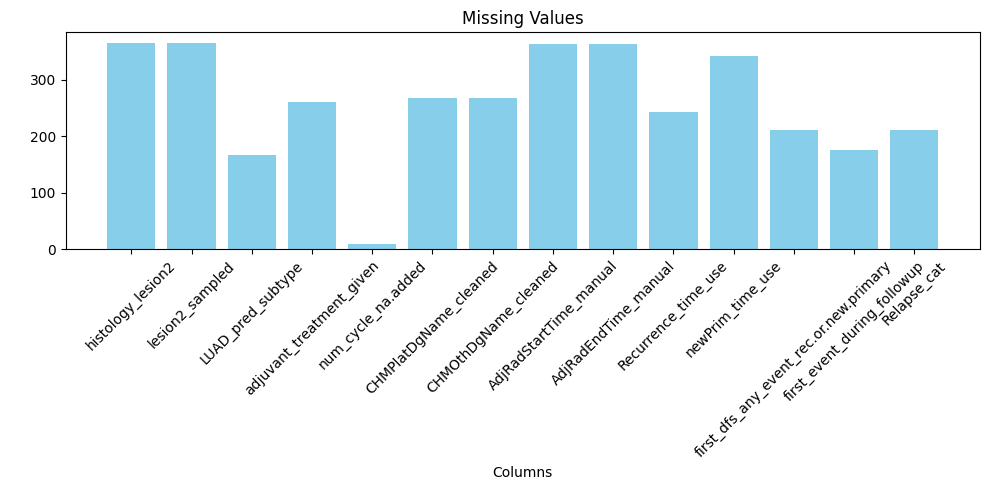

In [19]:
# Count NaN values in each column
null_counts = df.isnull().sum()

# Create a DataFrame to display column names and null counts
null_counts_df = pd.DataFrame({'Column': null_counts.index, 'Null Count': null_counts.values})

# print("\nColumns with number of NaN values:")
# print(null_counts_df)


# Filter columns with NaN values greater than 0
null_counts_filtered = null_counts_df[null_counts_df['Null Count'] > 0]

print("\nColumns with number of NaN values greater than 0:")
print(null_counts_filtered)

import matplotlib.pyplot as plt

# Plotting the bar chart for filtered columns
plt.figure(figsize=(10,5))
plt.bar(null_counts_filtered['Column'], null_counts_filtered['Null Count'], color='skyblue')
plt.xlabel('Columns')
plt.ylabel(' ')
plt.title('Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Histology lesion2 null values replaced with 'Unknown'

In [20]:
if not only_tree_features:
    # df['histology_lesion2'] = df['histology_lesion2'].fillna('Unknown')
    # df['lesion2_sampled'] = df['lesion2_sampled'].fillna('Unknown')
    # df['LUAD_pred_subtype'] = df['LUAD_pred_subtype'].fillna('Unknown')
    # df['adjuvant_treatment_given'] = df['adjuvant_treatment_given'].fillna('NA') 
    columns_to_fill = ['histology_lesion2', 'lesion2_sampled',]
    df[columns_to_fill] = df[columns_to_fill].fillna('Unknown')
    df['LUAD_pred_subtype'] = df['LUAD_pred_subtype'].fillna('NA')
    df['adjuvant_treatment_given'] = df['adjuvant_treatment_given'].fillna('NA') # For patients who did not receive adjuvant treatment, this column is NA.
    # df['num_cycle_na.added'] = df['num_cycle_na.added'].fillna(0)



In [21]:
len(df.columns)

59

## Dropping null columns 

In [22]:
drop = ['cruk_id',
        'tumour_id_muttable_cruk',
        'tumour_id_per_patient',
        'CHMPlatDgName_cleaned', 
        'CHMOthDgName_cleaned',
        'AdjRadStartTime_manual',
        'AdjRadEndTime_manual',
        'Recurrence_time_use', 
        'newPrim_time_use',
        'first_dfs_any_event_rec.or.new.primary',
        'first_event_during_followup',
        'Relapse_cat_new',
        'tx100']



In [23]:
if not only_tree_features:
    # Dropping columns with null entries
    clinical_df = df.drop(drop, axis = 1)
    list(clinical_df.columns)
else:
    clinical_df = df


### Dropping more columns based on suggestions from Dr Rob and Dr Tillman

Reasons (based on email):

    - Adjuvant treatment (features 26-28) is given after surgery, whereas it'd be better to use only information available at the time of surgery.

    - Features 29-35 relate to events after surgery

In [24]:
more_columns_to_drop = ['adjuvant_treatment_YN',
 'adjuvant_treatment_given',
 'num_cycle_na.added','cens_os',
 'cens_dfs',
 'cens_dfs_any_event',
 'dfs_time_any_event',
 'cens_lung_event',
 'lung_event_time',
 'Relapse_cat']

if not only_tree_features:
    # Dropping columns
    clinical_df = clinical_df.drop(more_columns_to_drop, axis = 1)
list(clinical_df.columns)

['age',
 'sex',
 'ethnicity',
 'cigs_perday',
 'years_smoking',
 'packyears',
 'smoking_status_merged',
 'is.family.lung',
 'ECOG_PS',
 'pathologyTNM',
 'pT_stage_per_patient',
 'pN_stage_per_patient',
 'LVI_per_patient',
 'PL_per_patient',
 'margin_status_per_patient',
 'size_pathology_per_patient',
 'Surgery_type',
 'histology_lesion1',
 'histology_lesion1_merged',
 'lesion1_sampled',
 'histology_lesion2',
 'lesion2_sampled',
 'histology_multi_full',
 'histology_multi_full_genomically.confirmed',
 'LUAD_pred_subtype',
 'os_time',
 'dfs_time',
 'D0N',
 'D1N',
 'J1N',
 'D0S',
 'D1S',
 'J1S',
 'D0L',
 'D1L',
 'J1L']

In [25]:
# Not needed for now
# clinical_df['num_cycle_na.added'] = clinical_df['num_cycle_na.added'].fillna('0')
# clinical_df['num_cycle_na.added'].unique()

## Label Encoding

 This technique converts each value in a column to a unique numerical value. 

 Label encoding is suitable when the categorical data has an ordinal relationship between the categories, as it preserves the order of the categories and allows the model to learn the relationship between them. Neural networks can learn from label encoded data by treating the numerical values as continuous variables and using them as input to the network.
 
 The problem with this is that the model might assume a relationship between these categories which doesn't exist. For example, if you label encode 'Low', 'Medium', and 'High' as 1, 2, and 3, the model might assume that 'High' is twice as important as 'Low' and 'Medium' is in between.

In [26]:
categorical_cols = clinical_df.select_dtypes(include=['object','bool','category']).columns.to_list()
len(categorical_cols)

18

In [27]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   age                                         378 non-null    int32   
 1   sex                                         378 non-null    object  
 2   ethnicity                                   378 non-null    object  
 3   cigs_perday                                 378 non-null    float64 
 4   years_smoking                               378 non-null    int32   
 5   packyears                                   378 non-null    float64 
 6   smoking_status_merged                       378 non-null    category
 7   is.family.lung                              378 non-null    bool    
 8   ECOG_PS                                     378 non-null    float64 
 9   pathologyTNM                                378 non-null    object  
 10  pT

In [28]:
# for column in categorical_cols:
#     print(f'{column} -',clinical_df[column].unique())
#     # print(clinical_df[column].value_counts())

#     print('==============')

Label encoding columns with less than 4 unique values is a common and effective technique for converting categorical variables into numerical variables, especially when the number of unique values is small. 

In [29]:
labelEncodedColumns = list()
for cat in categorical_cols:
    if len(clinical_df[cat].unique()) < 4:
        labelEncodedColumns.append(cat)
        print(cat,'=',len(clinical_df[cat].unique()), 'Unique Values')
len(labelEncodedColumns)

sex = 2 Unique Values
smoking_status_merged = 3 Unique Values
is.family.lung = 2 Unique Values
LVI_per_patient = 2 Unique Values
PL_per_patient = 2 Unique Values
margin_status_per_patient = 2 Unique Values
lesion1_sampled = 1 Unique Values
lesion2_sampled = 2 Unique Values


8

In [30]:
if not only_tree_features:
    le = LabelEncoder()

    clinical_df['lesion2_sampled'] = clinical_df['lesion2_sampled'].astype(str)

    for col in labelEncodedColumns:    
        clinical_df[col] = le.fit_transform(clinical_df[col])

### Label Encoding Skipped for these columns
Reason : High number of unique values


- Ethnicity = 11 Unique Values
- pathologyTNM = 6 Unique Values
- pT_stage_per_patient = 6 Unique Values
- histology_lesion1 = 9 Unique Values
- histology_lesion1_merged = 7 Unique Values
- histology_lesion2 = 6 Unique Values
- histology_multi_full = 9 Unique Values
- histology_multi_full_genomically.confirmed = 7 Unique Values
- LUAD_pred_subtype = 9 Unique Values
- num_cycle_na.added = 8 Unique Values
- Relapse_cat = 7 Unique Values




## Ordinal Encoding Specifically for these two columns

Suggested by Dr Robert Noble.

In [31]:

from sklearn.preprocessing import OrdinalEncoder

# ordinal_columns = ['pathologyTNM','pT_stage_per_patient']
if not only_tree_features:
    # Defining the order of the categories (by Dr Robert)
    PathologyTNM_categories_order = [['IA' ,'IB' ,'IIA', 'IIB' ,'IIIA' ,'IIIB']]

    # Creating an instance of OrdinalEncoder for PathologyTNM
    encoder = OrdinalEncoder(categories=PathologyTNM_categories_order)

    clinical_df['TNMordered'] = encoder.fit_transform(clinical_df[['pathologyTNM']])

    clinical_df['TNMordered'] = clinical_df['TNMordered'].astype(int) + 1

    # Cross checking encoding
    clinical_df[['pathologyTNM','TNMordered']]

    #==================================================================================================
    # Defining the order of the categories (by Dr Robert)
    pT_stage_categories_order = [['1a' ,'1b', '2a', '2b', '3', '4']]

    # Creating an instance of OrdinalEncoder for pT stage
    encoder = OrdinalEncoder(categories=pT_stage_categories_order)
    clinical_df['pT_stage_ordered'] = encoder.fit_transform(clinical_df[['pT_stage_per_patient']])

    clinical_df['pT_stage_ordered'] = clinical_df['pT_stage_ordered'].astype(int) + 1 

    # Cross checking encoding
    clinical_df[['pT_stage_per_patient','pT_stage_ordered']]

    print('Ordinal Encoding done')

# # Cross checking encoding
# clinical_df[['pathologyTNM','TNMordered']].head(50)

Ordinal Encoding done


In [32]:
# clinical_df.to_csv("20221109_TRACERx421_all_patient_df_Converted.csv")

## One-Hot Encoding


In [33]:
oneHot_columns = [category for category in categorical_cols if category not in labelEncodedColumns]
# oneHot_columns.remove('num_cycle_na.added')
oneHot_columns


['ethnicity',
 'pathologyTNM',
 'pT_stage_per_patient',
 'Surgery_type',
 'histology_lesion1',
 'histology_lesion1_merged',
 'histology_lesion2',
 'histology_multi_full',
 'histology_multi_full_genomically.confirmed',
 'LUAD_pred_subtype']

In [34]:
clinical_df_encoded = pd.get_dummies(clinical_df, columns=oneHot_columns)
# Replace True with 1 and False with 0
clinical_df_encoded = clinical_df_encoded.replace({True: 1, False: 0}).astype(int)


/var/folders/1m/wdgf0z3n3915ycmg2ckcz_p40000gn/T/ipykernel_6495/1451110257.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_df_encoded = clinical_df_encoded.replace({True: 1, False: 0}).astype(int)


## Features, Target & Standardisation

In [35]:
clinical_df = clinical_df_encoded
clinical_df

,age,sex,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,pN_stage_per_patient,LVI_per_patient,...,histology_multi_full_genomically.confirmed_Other,LUAD_pred_subtype_NA,LUAD_pred_subtype_acinar,LUAD_pred_subtype_cribriform,LUAD_pred_subtype_invasive_mucinous,LUAD_pred_subtype_lepidic,LUAD_pred_subtype_micropapillary,LUAD_pred_subtype_other,LUAD_pred_subtype_papillary,LUAD_pred_subtype_solid
0,68,0,20,35,35,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,81,1,44,49,109,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
2,60,1,20,38,38,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,85,1,10,25,12,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,63,1,40,51,102,2,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,59,0,15,43,32,2,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
374,66,1,20,54,54,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,0
375,64,1,12,27,16,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
376,78,0,10,30,15,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
X = clinical_df.drop(['os_time','dfs_time'], axis=1)
y = clinical_df[['os_time','dfs_time']]

In [37]:
len(X.columns)

96

### Splitting the Dataset

In [38]:
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X,y,test_size=0.3, random_state=42)
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X,y,test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [39]:
list(X_train['size_pathology_per_patient'])

[35,
 40,
 85,
 44,
 27,
 28,
 52,
 40,
 110,
 41,
 52,
 11,
 22,
 60,
 45,
 57,
 28,
 29,
 25,
 18,
 15,
 65,
 25,
 55,
 32,
 33,
 33,
 24,
 75,
 35,
 48,
 59,
 50,
 40,
 71,
 33,
 33,
 40,
 17,
 75,
 100,
 59,
 73,
 36,
 27,
 40,
 15,
 47,
 35,
 39,
 13,
 50,
 10,
 75,
 18,
 21,
 31,
 26,
 18,
 21,
 110,
 46,
 43,
 53,
 52,
 22,
 56,
 13,
 27,
 25,
 52,
 22,
 65,
 62,
 22,
 23,
 12,
 24,
 24,
 85,
 60,
 35,
 35,
 7,
 80,
 40,
 33,
 35,
 26,
 60,
 33,
 20,
 32,
 32,
 23,
 23,
 51,
 31,
 35,
 55,
 75,
 33,
 22,
 26,
 54,
 40,
 32,
 60,
 34,
 25,
 15,
 17,
 18,
 45,
 42,
 35,
 24,
 38,
 60,
 25,
 55,
 25,
 22,
 55,
 17,
 52,
 25,
 52,
 23,
 38,
 90,
 25,
 85,
 36,
 33,
 20,
 62,
 40,
 50,
 16,
 42,
 48,
 20,
 12,
 33,
 35,
 55,
 24,
 20,
 29,
 25,
 17,
 26,
 34,
 29,
 33,
 25,
 32,
 29,
 66,
 14,
 27,
 12,
 25,
 15,
 38,
 28,
 23,
 62,
 45,
 25,
 20,
 55,
 33,
 15,
 38,
 23,
 40,
 18,
 45,
 80,
 40,
 19,
 96,
 32,
 34,
 75,
 32,
 28,
 29,
 55,
 45,
 34,
 50,
 62,
 46,
 26,
 50,
 30,
 20

In [78]:
y_train[0:2]

,os_time,dfs_time
137,2147,2147
101,1894,1894


In [79]:
y_structured = np.array([(event, time) for event, time in zip(y_train["os_time"], y_train["dfs_time"])],
                               dtype=[('os_time', int), ('dfs_time', int)])

array([(2147, 2147), (1894, 1894), ( 106,   91), ( 476,  305),
       (1907, 1907), (1092, 1092), (  11,   11), (1537,  306),
       (1492, 1492), ( 968,  546), (1833, 1833), (1817, 1817),
       (1583, 1583), ( 510,  510), (  13,   13), ( 102,  102),
       (1232, 1232), (1350, 1350), (1538, 1538), ( 574,  442),
       (1376, 1376), (1078, 1078), (2011, 1242), (  56,   15),
       ( 605,  540), (1539, 1447), (1658, 1442), ( 164,  146),
       ( 445,  265), (1658, 1658), (1155,  935), ( 174,  109),
       ( 160,  127), (1989,  522), (1649, 1649), (1245,  633),
       (1763, 1763), ( 784,  784), (1001, 1001), ( 994,  994),
       (1419, 1419), (1787,  511), ( 515,  203), ( 487,  169),
       ( 926,  573), (1126, 1126), ( 650,  650), (1323,  325),
       ( 722,  430), (1831, 1831), (1184, 1184), (1337, 1337),
       (1982, 1982), (1743, 1743), (1409,  537), (1662, 1662),
       (1846, 1846), ( 508,  508), (1848, 1848), ( 839,  792),
       ( 152,  131), ( 585,  585), ( 649,  649), (1411,

In [89]:
y_train.to_numpy()

array([[2147, 2147],
       [1894, 1894],
       [ 106,   91],
       [ 476,  305],
       [1907, 1907],
       [1092, 1092],
       [  11,   11],
       [1537,  306],
       [1492, 1492],
       [ 968,  546],
       [1833, 1833],
       [1817, 1817],
       [1583, 1583],
       [ 510,  510],
       [  13,   13],
       [ 102,  102],
       [1232, 1232],
       [1350, 1350],
       [1538, 1538],
       [ 574,  442],
       [1376, 1376],
       [1078, 1078],
       [2011, 1242],
       [  56,   15],
       [ 605,  540],
       [1539, 1447],
       [1658, 1442],
       [ 164,  146],
       [ 445,  265],
       [1658, 1658],
       [1155,  935],
       [ 174,  109],
       [ 160,  127],
       [1989,  522],
       [1649, 1649],
       [1245,  633],
       [1763, 1763],
       [ 784,  784],
       [1001, 1001],
       [ 994,  994],
       [1419, 1419],
       [1787,  511],
       [ 515,  203],
       [ 487,  169],
       [ 926,  573],
       [1126, 1126],
       [ 650,  650],
       [1323,

In [90]:
from random_survival_forest.models import RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train.to_numpy(), y_train.to_numpy())

# Predict survival function for the test set
surv = rsf.predict_survival_function(X_test)

# To predict the survival time (the median survival time for each individual)
median_survival_time = [sfn(0.5) for sfn in surv]

# Evaluate model performance (example: concordance index)
from sklearn.metrics import concordance_index
c_index = concordance_index(y_test['time'], median_survival_time, event_observed=y_test['event'])

print(f"Concordance Index: {c_index}")

TypeError: exceptions must derive from BaseException

In [40]:
# # Standardize the features

# """ When preprocessing data, it is crucial to ensure that the test data remains unseen during the training phase to prevent data leakage. 
# Using fit_transform() on the training data ensures that the model only learns from the training data. Using transform()
# on the test data ensures that the test data is transformed using the same parameters (e.g., mean and standard deviation) learned from the training data."""

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train)

# y_test = scaler_y.transform(y_test)

## Linear Regression 
to add cv

### Baseline - Model 1

In [33]:
# Initialisng a linear regression model
model = LinearRegression()

model.fit(X_train, y_train)



LinearRegression()

In [34]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)

#prediction on training data
y_train_pred = model.predict(X_train)


### Training Set Evaluation

In [35]:
# Calculating the mean squared error of the predictions
LR_train_rmse_1 = mean_squared_error(y_train.values[:,0], y_train_pred[:,0])
LR_train_rmse_1

220880.6162635608

In [37]:
# Calculating the mean squared error of the predictions
LR_train_mse_1 = mean_squared_error(y_train.values[:,0], y_train_pred[:,0])
LR_train_mse_2 = mean_squared_error(y_train.values[:,1], y_train_pred[:,1])

# Calculating the mean absolute error of the predictions
LR_train_mae_1 = mean_absolute_error(y_train.values[:,0], y_train_pred[:,0])
LR_train_mae_2 = mean_absolute_error(y_train.values[:,1], y_train_pred[:,1])

# Calculating the root mean squared error of the predictions
LR_train_rmse_1 = np.sqrt(LR_train_mse_1)
LR_train_rmse_2 = np.sqrt(LR_train_mse_2)

LR_train_Rsquared_1 = r2_score(y_train.values[:,0], y_train_pred[:,0])
LR_train_Rsquared_2 = r2_score(y_train.values[:,1], y_train_pred[:,1])

print("Mean squared error for os_time on Training set:", LR_train_mse_1)
print("Root mean squared error for os_time on Training set:", LR_train_rmse_1)
print("Mean absolute error for os_time on Training set:", LR_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", LR_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", LR_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", LR_train_mae_2)


Mean squared error for os_time on Training set: 220880.6162635608
Root mean squared error for os_time on Training set: 469.9793785514007
Mean absolute error for os_time on Training set: 377.9920549587927
Mean squared error for dfs_time on Training set: 248982.86148398143
Root mean squared error for dfs_time on Training set: 498.98182480325016
Mean absolute error for dfs_time on Training set: 406.81116055078496


### Testing Set Evaluation

In [38]:
# Calculating the mean squared error of the predictions
LR_test_mse_1 = mean_squared_error(y_test.values[:,0], y_pred[:,0]).round(4)
LR_test_mse_2 = mean_squared_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
LR_test_mae_1 = mean_absolute_error(y_test.values[:,0], y_pred[:,0]).round(4)
LR_test_mae_2 = mean_absolute_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
LR_test_rmse_1 = np.sqrt(LR_test_mse_1).round(4)
LR_test_rmse_2 = np.sqrt(LR_test_mse_2).round(4)



LR_test_Rsquared_1 = r2_score(y_test.values[:,0], y_pred[:,0]).round(4)
LR_test_Rsquared_2 = r2_score(y_test.values[:,1], y_pred[:,1]).round(4)

print("Mean squared error for os_time on Testing set:", LR_test_mse_1)
print("Root mean squared error for os_time on Testing set:", LR_test_rmse_1)
print("Mean absolute error for os_time on Testing set:", LR_test_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Testing set:", LR_test_mse_2)
print("Root mean squared error for dfs_time on Testing set:", LR_test_rmse_2)
print("Mean absolute error for dfs_time on Testing set:", LR_test_mae_2)


AttributeError: 'float' object has no attribute 'round'

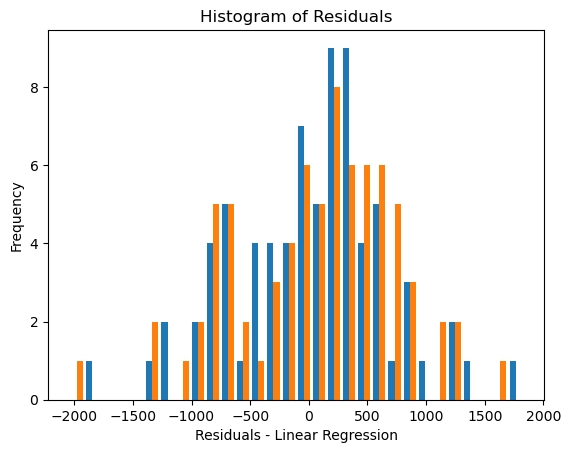

In [33]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Create a histogram of the residuals
plt.hist(residuals, bins=30)
plt.xlabel('Residuals - Linear Regression')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [34]:
ab = y_pred.tolist()

c = [i[0] for i in ab ]
d = [i[1] for i in ab ]


In [35]:
dfdd = pd.DataFrame({'os_time_LR':c,'dfs_time_LR':d})
dfdd.to_csv("LR.csv")


### Lasso Regression - Model 2

In [36]:
# Initialising a Lasso Regression model
model = Lasso(alpha=0.5)

# Fitting the model
model.fit(X_train, y_train)



Lasso(alpha=0.5)

In [37]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)

#prediction on training data
y_train_pred = model.predict(X_train)


In [38]:
# from sklearn.linear_model import Lasso
# from sklearn.model_selection import GridSearchCV

# # Define the model
# model = Lasso()

# # Define the grid of alpha values to search over
# alpha_grid = {'alpha': [0.1,0.001,0.0001,0.5, 1.0, 2.0, 5.0, 6.0,8.0,10]}

# # Perform the grid search
# grid_search = GridSearchCV(model, alpha_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Print the best alpha value and the corresponding score
# print("Best alpha value: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# model = Lasso(alpha=grid_search.best_params_['alpha'])

# model.fit(X_train,y_train)


In [39]:

# Make predictions on the testing data
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)

#prediction on training data
y_train_pred = model.predict(X_train)


In [40]:
# Calculating the mean squared error of the predictions
LasR_train_mse_1 = mean_squared_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_mse_2 = mean_squared_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
LasR_train_mae_1 = mean_absolute_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_mae_2 = mean_absolute_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
LasR_train_rmse_1 = np.sqrt(LasR_train_mse_1).round(4)
LasR_train_rmse_2 = np.sqrt(LasR_train_mse_2).round(4)

LasR_train_Rsquared_1 = r2_score(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_Rsquared_2 = r2_score(y_train.values[:,1], y_train_pred[:,1]).round(4)

print("Mean squared error for os_time on Training set:", LasR_train_mse_1)
print("Root mean squared error for os_time on Training set:", LasR_train_rmse_1)
print("Mean absolute error for os_time on Training set:", LasR_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", LasR_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", LasR_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", LasR_train_mae_2)


Mean squared error for os_time on Training set: 222390.398
Root mean squared error for os_time on Training set: 471.5829
Mean absolute error for os_time on Training set: 383.7107
Mean squared error for dfs_time on Training set: 250679.3079
Root mean squared error for dfs_time on Training set: 500.6788
Mean absolute error for dfs_time on Training set: 410.9595


In [41]:
# Calculating the mean squared error of the predictions
LasR_train_mse_1 = mean_squared_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_mse_2 = mean_squared_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
LasR_train_mae_1 = mean_absolute_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_mae_2 = mean_absolute_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
LasR_train_rmse_1 = np.sqrt(LasR_train_mse_1).round(4)
LasR_train_rmse_2 = np.sqrt(LasR_train_mse_2).round(4)

LasR_train_Rsquared_1 = r2_score(y_train.values[:,0], y_train_pred[:,0]).round(4)
LasR_train_Rsquared_2 = r2_score(y_train.values[:,1], y_train_pred[:,1]).round(4)

print("Mean squared error for os_time on Training set:", LasR_train_mse_1)
print("Root mean squared error for os_time on Training set:", LasR_train_rmse_1)
print("Mean absolute error for os_time on Training set:", LasR_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", LasR_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", LasR_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", LasR_train_mae_2)


Mean squared error for os_time on Training set: 222390.398
Root mean squared error for os_time on Training set: 471.5829
Mean absolute error for os_time on Training set: 383.7107
Mean squared error for dfs_time on Training set: 250679.3079
Root mean squared error for dfs_time on Training set: 500.6788
Mean absolute error for dfs_time on Training set: 410.9595


In [42]:
# Calculating the mean squared error of the predictions
LasR_test_mse_1 = mean_squared_error(y_test.values[:,0], y_pred[:,0]).round(4)
LasR_test_mse_2 = mean_squared_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
LasR_test_mae_1 = mean_absolute_error(y_test.values[:,0], y_pred[:,0]).round(4)
LasR_test_mae_2 = mean_absolute_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
LasR_test_rmse_1 = np.sqrt(LasR_test_mse_1).round(4)
LasR_test_rmse_2 = np.sqrt(LasR_test_mse_2).round(4)

LasR_test_Rsquared_1 = r2_score(y_test.values[:,0], y_pred[:,0]).round(4)
LasR_test_Rsquared_2 = r2_score(y_test.values[:,1], y_pred[:,1]).round(4)
print("Mean squared error for os_time on Testing set:", LasR_test_mse_1)
print("Root mean squared error for os_time on Testing set:", LasR_test_rmse_1)
print("Mean absolute error for os_time on Testing set:", LasR_test_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Testing set:", LasR_test_mse_2)
print("Root mean squared error for dfs_time on Testing set:", LasR_test_rmse_2)
print("Mean absolute error for dfs_time on Testing set:", LasR_test_mae_2)


Mean squared error for os_time on Testing set: 392762.3621
Root mean squared error for os_time on Testing set: 626.7076
Mean absolute error for os_time on Testing set: 500.3715
Mean squared error for dfs_time on Testing set: 418064.6099
Root mean squared error for dfs_time on Testing set: 646.5792
Mean absolute error for dfs_time on Testing set: 537.1427


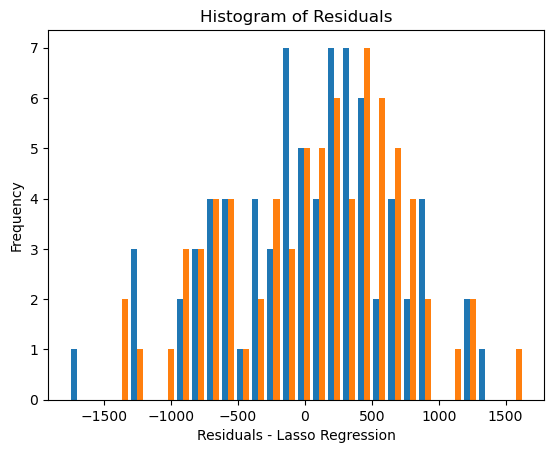

In [43]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Create a histogram of the residuals
plt.hist(residuals, bins=30)
plt.xlabel('Residuals - Lasso Regression')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [44]:
ab = y_pred.tolist()

c = [i[0] for i in ab ]
d = [i[1] for i in ab ]


In [45]:
# dfdd = pd.DataFrame({'os_time_LR':c,'dfs_time_LR':d})
# dfdd.to_csv("LR.csv")


### Ridge Regression - Model 3

In [46]:
from sklearn.linear_model import Ridge

# Initialising a Ridge Regression model
model = Ridge(alpha=0.5)

# Fitting the model
model.fit(X_train, y_train)



Ridge(alpha=0.5)

In [47]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)

#prediction on training data
y_train_pred = model.predict(X_train)


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculating the mean squared error of the predictions
RidR_train_mse_1 = mean_squared_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
RidR_train_mse_2 = mean_squared_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
RidR_train_mae_1 = mean_absolute_error(y_train.values[:,0], y_train_pred[:,0]).round(4)
RidR_train_mae_2 = mean_absolute_error(y_train.values[:,1], y_train_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
RidR_train_rmse_1 = np.sqrt(RidR_train_mse_1).round(4)
RidR_train_rmse_2 = np.sqrt(RidR_train_mse_2).round(4)

RidR_train_Rsquared_1 = r2_score(y_train.values[:,0], y_train_pred[:,0]).round(4)
RidR_train_Rsquared_2 = r2_score(y_train.values[:,1], y_train_pred[:,1]).round(4)

print("Mean squared error for os_time on Training set:", RidR_train_mse_1)
print("Root mean squared error for os_time on Training set:", RidR_train_rmse_1)
print("Mean absolute error for os_time on Training set:", RidR_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", RidR_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", RidR_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", RidR_train_mae_2)


Mean squared error for os_time on Training set: 223026.5645
Root mean squared error for os_time on Training set: 472.2569
Mean absolute error for os_time on Training set: 384.3771
Mean squared error for dfs_time on Training set: 251181.882
Root mean squared error for dfs_time on Training set: 501.1805
Mean absolute error for dfs_time on Training set: 412.2466


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculating the mean squared error of the predictions
RidR_test_mse_1 = mean_squared_error(y_test.values[:,0], y_pred[:,0]).round(4)
RidR_test_mse_2 = mean_squared_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
RidR_test_mae_1 = mean_absolute_error(y_test.values[:,0], y_pred[:,0]).round(4)
RidR_test_mae_2 = mean_absolute_error(y_test.values[:,1], y_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
RidR_test_rmse_1 = np.sqrt(RidR_test_mse_1).round(4)
RidR_test_rmse_2 = np.sqrt(RidR_test_mse_2).round(4)


RidR_test_Rsquared_1 = r2_score(y_test.values[:,0], y_pred[:,0]).round(4)
RidR_test_Rsquared_2 = r2_score(y_test.values[:,1], y_pred[:,1]).round(4)

print("Mean squared error for os_time on Testing set:", RidR_test_mse_1)
print("Root mean squared error for os_time on Testing set:", RidR_test_rmse_1)
print("Mean absolute error for os_time on Testing set:", RidR_test_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Testing set:", RidR_test_mse_2)
print("Root mean squared error for dfs_time on TesRidR_ting set:", RidR_test_rmse_2)
print("Mean absolute error for dfs_time on Testing set:", RidR_test_mae_2)


Mean squared error for os_time on Testing set: 411031.6975
Root mean squared error for os_time on Testing set: 641.1175
Mean absolute error for os_time on Testing set: 506.7512
Mean squared error for dfs_time on Testing set: 412513.3018
Root mean squared error for dfs_time on TesRidR_ting set: 642.272
Mean absolute error for dfs_time on Testing set: 535.4068


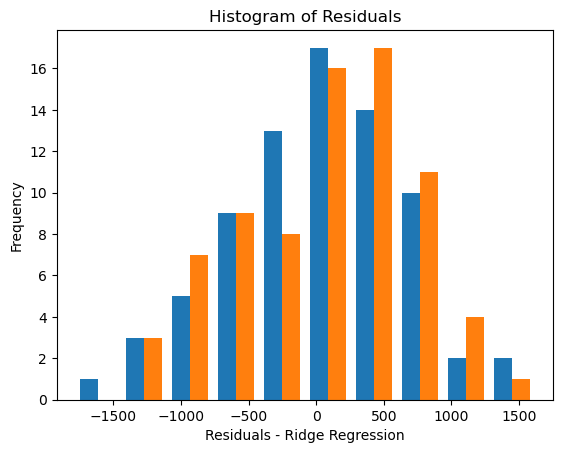

In [50]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Create a histogram of the residuals
plt.hist(residuals, bins=10)
plt.xlabel('Residuals - Ridge Regression')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [51]:
ab = y_pred.tolist()

c = [i[0] for i in ab ]
d = [i[1] for i in ab ]


In [52]:
# dfdd = pd.DataFrame({'os_time_LR':c,'dfs_time_LR':d})
# dfdd.to_csv("LR.csv")


## Feed Forward Neural Network

In [53]:
# # Converting to tensors
# X_train = torch.tensor(X_train)
# y_train = torch.tensor(y_train)
# X_test = torch.tensor(X_test)
# y_test = torch.tensor(y_test)

In [54]:
# Converting to tensors
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
# y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)
# y_test = torch.FloatTensor(y_test.values)

from torch.utils.data import TensorDataset, DataLoader

# Create a TensorDataset from the training data
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create a DataLoader from the TensorDataset
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data,)


In [55]:
print(X_train.size(),
X_test.size(),
y_train.size(),
y_test.size())

torch.Size([302, 96]) torch.Size([76, 96]) torch.Size([302, 2]) torch.Size([76, 2])


In [56]:
class feedforwardNN(nn.Module):
    def __init__(self,input_size):
        super(feedforwardNN,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,2)
        self.relu= nn.ReLU()
        

    def forward(self,x):
        x  = self.relu(self.fc1(x))
        x  = self.relu(self.fc2(x))
        x  = self.fc3(x)

        return x
    

In [57]:
X_train.shape[1]

96

In [58]:
# 3. Initializing the model, loss function, and optimizer
input_size = X_train.shape[1]
model = feedforwardNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)


import random

# Set random seeds for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU
        torch.backends.cudnn.deterministic = True  # Force cuDNN to be deterministic
        torch.backends.cudnn.benchmark = False

# Set the seed (choose any number, e.g., 42)
set_seed(42)

# Training loop with reproducibility
num_epochs = 100
batch_size = 20

In [59]:
# Training the model

num_epochs = 100
batch_size = 32


for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0
    for i in range(0,len(X_train), batch_size):

        Xbatch = X_train #[i:i+batch_size]
        ybatch = y_train #[i:i+batch_size]


        # Forward pass
        
        outputs = model(Xbatch)
        loss = criterion(outputs,ybatch)
        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 # Accumulate loss
        epoch_loss += loss.item()
        batch_count += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / batch_count

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


Epoch [10/100], Average Loss: 680062.0312
Epoch [20/100], Average Loss: 519572.4188
Epoch [30/100], Average Loss: 473449.1688
Epoch [40/100], Average Loss: 430494.4625
Epoch [50/100], Average Loss: 402470.6000
Epoch [60/100], Average Loss: 386014.0469
Epoch [70/100], Average Loss: 372267.0531
Epoch [80/100], Average Loss: 358828.1281
Epoch [90/100], Average Loss: 344238.9813
Epoch [100/100], Average Loss: 329014.1125


In [60]:
train_loader.dataset.tensors[0][0].size()

torch.Size([96])

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

# Define the model
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # Assuming 2 output nodes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Define the training loop
def train(model, optimizer, criterion, train_loader, num_epochs):
    min_loss = float('inf')  # Initialize min_loss inside the function
    best_model_params = None
    
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the minimum loss and save the model parameters if necessary
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_model_params = model.state_dict()

    # Load the best model parameters if they exist
    if best_model_params is not None:
        model.load_state_dict(best_model_params)
    
    return min_loss  # Return the minimum loss

# Define the evaluation function
def evaluate(model, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # No need to compute gradients
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(test_loader)  # Average loss over the test dataset

# Loop over the hidden sizes, learning rates, num_epochs, and optimizers
overall_min_test_loss = float('inf')
best_model_params = {
    'hidden_size': None,
    'learning_rate': None,
    'num_epochs': None,
    'optimizer': None
}


# Define the hyperparameters
input_size = X_train.size()[1]  # Assuming X_train is defined
hidden_sizes = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]  # Different learning rates
num_epochs_options = [100, 500]  # Different epoch counts
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam}

# for dropout in [0.2,0.5,0.8]:
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for num_epochs in num_epochs_options:
            for optimizer_name, optimizer_class in optimizers.items():
                # Initialize the model
                model = FeedforwardNN(input_size, hidden_size, 0.5)

                # Define the loss function and optimizer
                criterion = nn.MSELoss()  # Using MSELoss here as per your initial setup
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)

                # Train the model and get the minimum training loss
                train_min_loss = train(model, optimizer, criterion, train_loader, num_epochs)

                # Evaluate the model on the test set
                test_loss = evaluate(model, criterion, test_loader)

                # Print the results for this variation
                print(f"Hidden size: {hidden_size}, Learning rate: {learning_rate}, "
                    f"Epochs: {num_epochs}, Optimizer: {optimizer_name}, "
                    f"Training loss: {train_min_loss}, Test loss: {test_loss}")

                # Update the overall minimum test loss and the best parameters if necessary
                if test_loss < overall_min_test_loss:
                    overall_min_test_loss = test_loss
                    best_model_params['hidden_size'] = hidden_size
                    best_model_params['learning_rate'] = learning_rate
                    best_model_params['num_epochs'] = num_epochs
                    best_model_params['optimizer'] = optimizer_name
                    # best_model_params['dropout_rate'] = dropout
                    best_model_params['model_state_dict'] = model.state_dict()  # Save the best model state

# Print the best parameters and the corresponding minimum test loss
print(f"Best parameters: {best_model_params}, Minimum test loss: {overall_min_test_loss}")


Hidden size: 32, Learning rate: 0.001, Epochs: 100, Optimizer: SGD, Training loss: 496384344064.0, Test loss: 495744279390.3158
Hidden size: 32, Learning rate: 0.001, Epochs: 100, Optimizer: Adam, Training loss: 279191.59375, Test loss: 500600.25791529607
Hidden size: 32, Learning rate: 0.001, Epochs: 500, Optimizer: SGD, Training loss: 16103297253376.0, Test loss: nan
Hidden size: 32, Learning rate: 0.001, Epochs: 500, Optimizer: Adam, Training loss: 108738.5078125, Test loss: 409487.22999331827
Hidden size: 32, Learning rate: 0.01, Epochs: 100, Optimizer: SGD, Training loss: inf, Test loss: nan
Hidden size: 32, Learning rate: 0.01, Epochs: 100, Optimizer: Adam, Training loss: 154293.265625, Test loss: 370620.01732755965
Hidden size: 32, Learning rate: 0.01, Epochs: 500, Optimizer: SGD, Training loss: inf, Test loss: nan
Hidden size: 32, Learning rate: 0.01, Epochs: 500, Optimizer: Adam, Training loss: 126221.0859375, Test loss: 403744.1778146844
Hidden size: 32, Learning rate: 0.1, E

In [62]:

class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # Assuming 2 output nodes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = self.fc3(x)
        return x
    

In [63]:
best_model_params['optimizer']

'Adam'

In [64]:
input_size = X_train.size()[1]  # Assuming X_train is defined
hidden_sizes = best_model_params['hidden_size']
learning_rate = best_model_params['learning_rate']  # Different learning rates
num_epochs = best_model_params['num_epochs']  # Different epoch counts
optimizer = best_model_params['optimizer']
dropout_rate = best_model_params['dropout_rate']
model = FeedforwardNN(input_size, hidden_size, dropout_rate)
optimizer = {
    
    'Adam': optim.Adam}

# def train(model, optimizer, criterion, train_loader, num_epochs):
#     min_loss = float('inf')  # Initialize min_loss inside the function
#     best_model_params = None
    
#     for epoch in range(num_epochs):
#         for inputs, labels in train_loader:
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Update the minimum loss and save the model parameters if necessary
#         if loss.item() < min_loss:
#             min_loss = loss.item()
#             best_model_params = model.state_dict()

#     # Load the best model parameters if they exist
#     if best_model_params is not None:
#         model.load_state_dict(best_model_params)
    
#     return min_loss

optimizer = optim.Adam(model.parameters(), lr= best_model_params['learning_rate'])

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0
    for i in range(0,len(X_train), batch_size):

        Xbatch = X_train #[i:i+batch_size]
        ybatch = y_train #[i:i+batch_size]


        # Forward pass
        
        outputs = model(Xbatch)
        loss = criterion(outputs,ybatch)
        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 # Accumulate loss
        epoch_loss += loss.item()
        batch_count += 1


    # Calculate average loss for the epoch
    avg_loss = epoch_loss / batch_count

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


KeyError: 'dropout_rate'

In [77]:
model

FeedforwardNN(
  (fc1): Linear(in_features=96, out_features=256, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Ensure the model is in evaluation mode if necessary
model.eval()

# Get predictions from the model on the training data
with torch.no_grad():  # Ensuring no gradients are being computed
    y_train_pred = model(X_train)


y_train_pred = model(X_train).cpu().detach().numpy()


# Calculating the mean squared error of the predictions
NN_train_mse_1 = mean_squared_error(y_train[:,0], y_train_pred[:,0]).round(4)
NN_train_mse_2 = mean_squared_error(y_train[:,1], y_train_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
NN_train_mae_1 = mean_absolute_error(y_train[:,0], y_train_pred[:,0]).round(4)
NN_train_mae_2 = mean_absolute_error(y_train[:,1], y_train_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
NN_train_rmse_1 = np.sqrt(NN_train_mse_1).round(4)
NN_train_rmse_2 = np.sqrt(NN_train_mse_2).round(4)

NN_train_Rsquared_1 = r2_score(y_train[:,0], y_train_pred[:,0]).round(4)
NN_train_Rsquared_2 = r2_score(y_train[:,1], y_train_pred[:,1]).round(4)

print("Mean squared error for os_time on Training set:", NN_train_mse_1)
print("Root mean squared error for os_time on Training set:", NN_train_rmse_1)
print("Mean absolute error for os_time on Training set:", NN_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", NN_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", NN_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", NN_train_mae_2)

Mean squared error for os_time on Training set: 401489.66
Root mean squared error for os_time on Training set: 633.6322
Mean absolute error for os_time on Training set: 556.4856
Mean squared error for dfs_time on Training set: 443111.22
Root mean squared error for dfs_time on Training set: 665.666
Mean absolute error for dfs_time on Training set: 601.9422


In [80]:
y_pred = model(X_test).cpu().detach().numpy()

# Calculating the mean squared error of the predictions
NN_test_mse_1 = mean_squared_error(y_test[:,0], y_pred[:,0]).round(4)
NN_test_mse_2 = mean_squared_error(y_test[:,1], y_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
NN_test_mae_1 = mean_absolute_error(y_test[:,0], y_pred[:,0]).round(4)
NN_test_mae_2 = mean_absolute_error(y_test[:,1], y_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
NN_test_rmse_1 = np.sqrt(NN_test_mse_1).round(4)
NN_test_rmse_2 = np.sqrt(NN_test_mse_2).round(4)


NN_test_Rsquared_1 = r2_score(y_test[:,0], y_pred[:,0]).round(4)
NN_test_Rsquared_2 = r2_score(y_test[:,1], y_pred[:,1]).round(4)


print("Mean squared error for os_time on Testing set:", NN_test_mse_1)
print("Root mean squared error for os_time on Testing set:", NN_test_rmse_1)
print("Mean absolute error for os_time on Testing set:", NN_test_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Testing set:", NN_test_mse_2)
print("Root mean squared error for dfs_time on Testing set:", NN_test_rmse_2)
print("Mean absolute error for dfs_time on Testing set:", NN_test_mae_2)


Mean squared error for os_time on Testing set: 438955.12
Root mean squared error for os_time on Testing set: 662.5368
Mean absolute error for os_time on Testing set: 580.7756
Mean squared error for dfs_time on Testing set: 467417.8
Root mean squared error for dfs_time on Testing set: 683.6796
Mean absolute error for dfs_time on Testing set: 613.6178


### NN based evaluation

In [64]:
outputs = model(Xbatch)
loss1 = criterion(outputs[:, 0], ybatch[:, 0])
loss2 = criterion(outputs[:, 1], ybatch[:, 1])
total_loss = (loss1 + loss2) / 2

print(f"Loss for feature 1: {loss1.item():.4f}")
print(f"Loss for feature 2: {loss2.item():.4f}")
print(f"Combined loss: {total_loss.item():.4f}")

Loss for feature 1: 235611.9219
Loss for feature 2: 259089.7031
Combined loss: 247350.8125


In [65]:
# Evaluating the model

with torch.no_grad():

    y_pred = model(X_test)

    test_loss = criterion(y_pred,y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    


Test Loss: 355050.2188


In [66]:
# With model.eval()
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred_eval_mode = model(X_test)  # Forward pass
    test_loss_eval_mode = criterion(y_pred_eval_mode, y_test)
print(f'Test Loss with model.eval(): {test_loss_eval_mode.item():.4f}')

Test Loss with model.eval(): 355050.2188


In [67]:
# # Inverse transform
# y_pred_inv = scaler_y.inverse_transform(y_pred).astype(int)
# y_test_inv = scaler_y.inverse_transform(y_test).astype(int)

In [68]:
# y_test_df['os_time_predicted'] = y_pred_inv.astype(int)[:,0]
# y_test_df['dfs_time_predicted'] = y_pred_inv.astype(int)[:,1]

In [69]:
# y_test_df.to_csv('feedforcritercrwardNN_predicted.csv', index=False)

In [70]:
# df = y_test_df[:10]

# # Plotting real vs predicted values
# plt.figure(figsize=(10, 6))

# # Plot os_time and os_time_predicted
# plt.plot(df.index, df['os_time'], marker='o', label='os_time (real)')
# plt.plot(df.index, df['os_time_predicted'], marker='o', linestyle='--', color='r', label='os_time_predicted')

# # # Plot dfs_time and dfs_time_predicted
# # plt.plot(df.index, df['dfs_time'], marker='o', label='dfs_time (real)')
# # plt.plot(df.index, df['dfs_time_predicted'], marker='o', linestyle='--', color='g', label='dfs_time_predicted')

# plt.xlabel('Index')
# plt.ylabel('Time')
# plt.title('Real vs Predicted Values')
# plt.legend()
# plt.grid(True)
# plt.show()

## Boosting Model
XGBoost

In [44]:
from xgboost import XGBRegressor
from xgboost import plot_importance

# Define the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror',  n_estimators=20)

xgb_model.fit(X_train, y_train)

/opt/anaconda3/envs/mlcancer/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import to_graphviz

# Define the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=20)

xgb_model.fit(X_train, y_train)

# # Plot feature importance
# fig, ax = plt.subplots(figsize=(10, 10))
# plot_importance(xgb_model, ax=ax)
# plt.show()

# # Plot the first tree
# plot_tree(xgb_model, num_trees=0)
# plt.show()

# # Export the model to a Graphviz dot file
# graph = to_graphviz(xgb_model, num_trees=0)
# graph.render("tree", view=True, format="png")

/opt/anaconda3/envs/mlcancer/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance

# Define the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror',  n_estimators=20)

# Define the parameters for grid search
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],            # Depth of each tree
    'learning_rate': [0.001, 0.01, 0.1, 0.2],    # Step size shrinkage
    'n_estimators': [10, 20, 50, 100],        # Number of boosting rounds
    # 'subsample': [0.8, 1],                # Fraction of samples used per tree
    # 'colsample_bytree': [0.8, 1],         # Fraction of features used per tree
    # 'gamma': [0, 0.1, 0.2],               # Minimum loss reduction required
    # 'reg_alpha': [0, 0.1, 1],             # L1 regularization
    # 'reg_lambda': [1, 1.5, 2],
    # 'device' : ['cuda'],
    # 'tree_method': ['hist']            # L2 regularization
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1) # GridSearchCV maximizes the scoring function, so mean_squared_error is negated. This way, minimizing the MSE becomes equivalent to maximizing the negative MSE.

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best estimator and evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

<Figure size 1000x800 with 0 Axes>

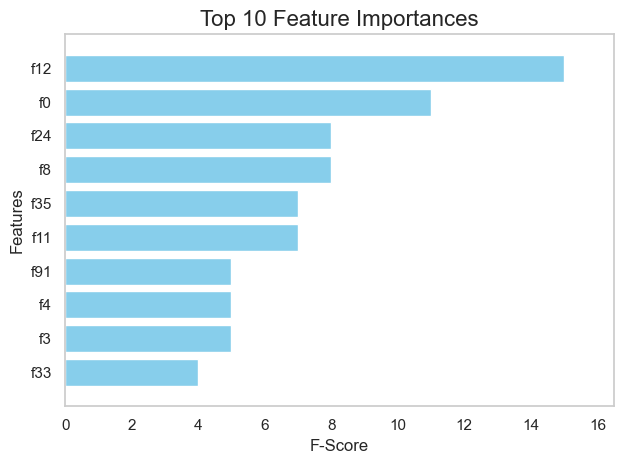

In [103]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming best_model is already defined as an XGBoost model
# X_train is a Pandas DataFrame with the feature names

# Set the Seaborn style for better visuals
sns.set(style="whitegrid")

# Plot the feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10, height=0.8, 
                    grid=False, color="skyblue", show_values=False)

# Add titles and labels for clarity
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [72]:

# Predictions
# predictions = model.predict(X_test)
y_train_pred = best_model.predict(X_train)


# XG_train_mse_1 = mean_squared_error(y_train, y_train_pred, multioutput='raw_values')
# XG_train_rmse_1 = np.sqrt(XG_train_mse_1)
# print(f"RMSE for os_time: {train_mse_1[0]:.4f}")
# print(f"RMSE for dfs_time: {train_rmse_1[1]:.4f}")



XG_train_mse_1 = mean_squared_error(y_train[:,0], y_train_pred[:,0]).round(4)
XG_train_mse_2 = mean_squared_error(y_train[:,1], y_train_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
XG_train_mae_1 = mean_absolute_error(y_train[:,0], y_train_pred[:,0]).round(4)
XG_train_mae_2 = mean_absolute_error(y_train[:,1], y_train_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
XG_train_rmse_1 = np.sqrt(XG_train_mse_1).round(4)
XG_train_rmse_2 = np.sqrt(XG_train_mse_2).round(4)

XG_train_Rsquared_1 = r2_score(y_train[:,0], y_train_pred[:,0]).round(4)
XG_train_Rsquared_2 = r2_score(y_train[:,1], y_train_pred[:,1]).round(4)

print("Mean squared error for os_time on Training set:", XG_train_mse_1)
print("Root mean squared error for os_time on Training set:", XG_train_rmse_1)
print("Mean absolute error for os_time on Training set:", XG_train_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Training set:", XG_train_mse_2)
print("Root mean squared error for dfs_time on Training set:", XG_train_rmse_2)
print("Mean absolute error for dfs_time on Training set:", XG_train_mae_2)


Mean squared error for os_time on Training set: 275876.88
Root mean squared error for os_time on Training set: 525.2398
Mean absolute error for os_time on Training set: 441.8912
Mean squared error for dfs_time on Training set: 296528.6
Root mean squared error for dfs_time on Training set: 544.5444
Mean absolute error for dfs_time on Training set: 467.0456


In [73]:
y_pred = best_model.predict(X_test)


# XG_testmse_1 = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
# XG_test_rmse_1 = np.sqrt(test_mse_1)
# print(f"RMSE for os_time: {train_mse_1[0]:.4f}")
# print(f"RMSE for dfs_time: {train_rmse_1[1]:.4f}")



XG_test_mse_1 = mean_squared_error(y_test[:,0], y_pred[:,0]).round(4)
XG_test_mse_2 = mean_squared_error(y_test[:,1], y_pred[:,1]).round(4)

# Calculating the mean absolute error of the predictions
XG_test_mae_1 = mean_absolute_error(y_test[:,0], y_pred[:,0]).round(4)
XG_test_mae_2 = mean_absolute_error(y_test[:,1], y_pred[:,1]).round(4)

# Calculating the root mean squared error of the predictions
XG_test_rmse_1 = np.sqrt(XG_test_mse_1).round(4)
XG_test_rmse_2 = np.sqrt(XG_test_mse_2).round(4)


XG_test_Rsquared_1 = r2_score(y_test[:,0], y_pred[:,0]).round(4)
XG_test_Rsquared_2 = r2_score(y_test[:,1], y_pred[:,1]).round(4)

print("Mean squared error for os_time on Testing set:", XG_test_mse_1)
print("Root mean squared error for os_time on Testing set:", XG_test_rmse_1)
print("Mean absolute error for os_time on Testing set:", XG_test_mae_1)
print("="*10)
print("Mean squared error for dfs_time on Testing set:", XG_test_mse_2)
print("Root mean squared error for dfs_time on Testing set:", XG_test_rmse_2)
print("Mean absolute error for dfs_time on Testing set:", XG_test_mae_2)


Mean squared error for os_time on Testing set: 345889.66
Root mean squared error for os_time on Testing set: 588.1238
Mean absolute error for os_time on Testing set: 491.8893
Mean squared error for dfs_time on Testing set: 351809.88
Root mean squared error for dfs_time on Testing set: 593.1356
Mean absolute error for dfs_time on Testing set: 515.9031


### Feature importance

In [74]:


# importance = model.get_score(importance_type='gain')
# importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
# print("\nTop 10 important features:")
# for feat, score in importance[:10]:
#     print(f"{feat}: {score:.2f}")

In [75]:
# y_test_df['os_time_XGboost'] = scaler_y.inverse_transform(predictions).astype(int)[:,0]
# y_test_df['dfs_time_XGboost'] = scaler_y.inverse_transform(predictions).astype(int)[:,1]

In [76]:
# y_test_df.to_csv("NN and XGboost.csv", index = False)

In [77]:
# # Create a dictionary to map 'f3' style names to original names
# feature_name_map = {f'f{i}': name for i, name in enumerate(X_train_df)}
# # feature_name_map

In [78]:
# # Print feature importance with original names
# feature_imp_dict = dict()
# for f, importance_score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
#     original_name = feature_name_map.get(f, f) 
#     feature_imp_dict[f"{original_name}"] = importance_score
# feature_imp_dict

In [79]:

# import matplotlib.pyplot as plt

# # Plotting the bar chart for filtered columns
# plt.figure(figsize=(12,5))
# plt.bar(list(feature_imp_dict.keys()),list(feature_imp_dict.values()) , color='skyblue')
# plt.xlabel('Columns')
# plt.ylabel(' ')
# plt.title('Feature Importance')
# plt.xticks(rotation=60)
# plt.tight_layout()
# plt.show()


## Results

#### Training Results for Overall Survival (OS) time

In [80]:

resultsdf_train_os = pd.DataFrame() 
resultsdf_train_os['Mean Squared Error (MSE)'] = [LR_train_mse_1, LasR_train_mse_1, RidR_train_mse_1,NN_train_mse_1,XG_train_mse_1]
resultsdf_train_os['Root Mean Squared Error (RMSE)'] = [LR_train_rmse_1, LasR_train_rmse_1, RidR_train_rmse_1,NN_train_rmse_1,XG_train_rmse_1]
resultsdf_train_os['Mean Absolute Error (MAE)'] = [LR_train_mae_1, LasR_train_mae_1, RidR_train_mae_1,NN_train_mae_1,XG_train_mae_1]
resultsdf_train_os['Rsquared Error (R2)'] = [LR_train_Rsquared_1, LasR_train_Rsquared_1, RidR_train_Rsquared_1,NN_train_Rsquared_1,XG_train_Rsquared_1]


resultsdf_train_os.index = ('Linear Regression','Lasso Regression','Ridge Regression','Neural Network', 'XGBoost', )

resultsdf_train_os

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Rsquared Error (R2)
Linear Regression,220880.616300,469.979400,377.992100,0.446151
Lasso Regression,222390.398000,471.582900,383.710700,0.442400
Ridge Regression,223026.564500,472.256900,384.377100,0.440800
Neural Network,235611.921875,485.398712,396.877106,0.409200
XGBoost,275876.875000,525.239807,441.891205,0.308200


#### Testing Results for Overall Survival (OS) time

In [81]:
# Testing Set OS time
resultsdf_test_os = pd.DataFrame() 
resultsdf_test_os['Mean Squared Error (MSE)'] = [LR_test_mse_1, LasR_test_mse_1, RidR_test_mse_1,NN_test_mse_1,XG_test_mse_1]
resultsdf_test_os['Root Mean Squared Error (RMSE)'] = [LR_test_rmse_1, LasR_test_rmse_1, RidR_test_rmse_1,NN_test_rmse_1,XG_test_rmse_1]
resultsdf_test_os['Mean Absolute Error (MAE)'] = [LR_test_mae_1, LasR_test_mae_1, RidR_test_mae_1,NN_test_mae_1,XG_test_mae_1]
resultsdf_test_os['Rsquared Error (R2)'] = [LR_test_Rsquared_1, LasR_test_Rsquared_1, RidR_test_Rsquared_1,NN_test_Rsquared_1,XG_test_Rsquared_1]


resultsdf_test_os.index = ('Linear Regression','Lasso Regression','Ridge Regression','Neural Network', 'XGBoost', )

resultsdf_test_os

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Rsquared Error (R2)
Linear Regression,436652.17680,660.796600,517.441500,-0.0016
Lasso Regression,392762.36210,626.707600,500.371500,0.0990
Ridge Regression,411031.69750,641.117500,506.751200,0.0571
Neural Network,344798.68750,587.195618,473.488800,0.2091
XGBoost,345889.65625,588.123779,491.889313,0.2066


#### Training Results for Disease Free Survival (DFS) time

In [82]:
# Training Set dfs time
resultsdf_train_dfs = pd.DataFrame() 
resultsdf_train_dfs['Mean Squared Error (MSE)'] = [LR_train_mse_2, LasR_train_mse_2, RidR_train_mse_2,NN_train_mse_2,XG_train_mse_2]
resultsdf_train_dfs['Root Mean Squared Error (RMSE)'] = [LR_train_rmse_2, LasR_train_rmse_2, RidR_train_rmse_2,NN_train_rmse_2,XG_train_rmse_2]
resultsdf_train_dfs['Mean Absolute Error (MAE)'] = [LR_train_mae_2, LasR_train_mae_2, RidR_train_mae_2,NN_train_mae_2,XG_train_mae_2]
resultsdf_train_dfs['Rsquared Error (R2)'] = [LR_train_Rsquared_2, LasR_train_Rsquared_2, RidR_train_Rsquared_2,NN_train_Rsquared_2,XG_train_Rsquared_2]


resultsdf_train_dfs.index = ('Linear Regression','Lasso Regression','Ridge Regression','Neural Network', 'XGBoost', )

resultsdf_train_dfs

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Rsquared Error (R2)
Linear Regression,248982.86150,498.981800,406.811200,0.436047
Lasso Regression,250679.30790,500.678800,410.959500,0.432200
Ridge Regression,251181.88200,501.180500,412.246600,0.431100
Neural Network,259089.65625,509.008514,430.401215,0.413200
XGBoost,296528.59375,544.544373,467.045593,0.328400


#### Testing Results for Disease Free Survival (DFS) time

In [83]:
# Testing Set dfs time
resultsdf_test_dfs = pd.DataFrame() 
resultsdf_test_dfs['Mean Squared Error (MSE)'] = [LR_test_mse_2, LasR_test_mse_2, RidR_test_mse_2,NN_test_mse_2,XG_test_mse_2]
resultsdf_test_dfs['Root Mean Squared Error (RMSE)'] = [LR_test_rmse_2, LasR_test_rmse_2, RidR_test_rmse_2,NN_test_rmse_2,XG_test_rmse_2]
resultsdf_test_dfs['Mean Absolute Error (MAE)'] = [LR_test_mae_2, LasR_test_mae_2, RidR_test_mae_2,NN_test_mae_2,XG_test_mae_2]
resultsdf_test_dfs['Rsquared Error (R2)'] = [LR_test_Rsquared_2, LasR_test_Rsquared_2, RidR_test_Rsquared_2,NN_test_Rsquared_2,XG_test_Rsquared_2]


resultsdf_test_dfs.index = ('Linear Regression','Lasso Regression','Ridge Regression','Neural Network', 'XGBoost')

resultsdf_test_dfs.round(2)

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Rsquared Error (R2)
Linear Regression,459350.12,677.75,550.28,-0.01
Lasso Regression,418064.61,646.58,537.14,0.08
Ridge Regression,412513.30,642.27,535.41,0.10
Neural Network,365301.75,604.40,509.90,0.20
XGBoost,351809.88,593.14,515.90,0.23


In [84]:
resultsdf_train_os.to_csv('os_train.csv')
resultsdf_train_dfs.to_csv('dfs_train.csv')

resultsdf_test_os.to_csv('os_test.csv')
resultsdf_test_dfs.to_csv('dfs_test.csv')

In [85]:
resultsdf_test_os['Mean Squared Error (MSE)']

Linear Regression    436652.17680
Lasso Regression     392762.36210
Ridge Regression     411031.69750
Neural Network       344798.68750
XGBoost              345889.65625
Name: Mean Squared Error (MSE), dtype: float64

In [86]:
print(resultsdf_train_os['Root Mean Squared Error (RMSE)'].tolist())
print(resultsdf_test_os['Root Mean Squared Error (RMSE)'].tolist())

[469.9794, 471.5829, 472.2569, 485.3987121582031, 525.2398071289062]
[660.7966, 626.7076, 641.1175, 587.1956176757812, 588.123779296875]


# Plots

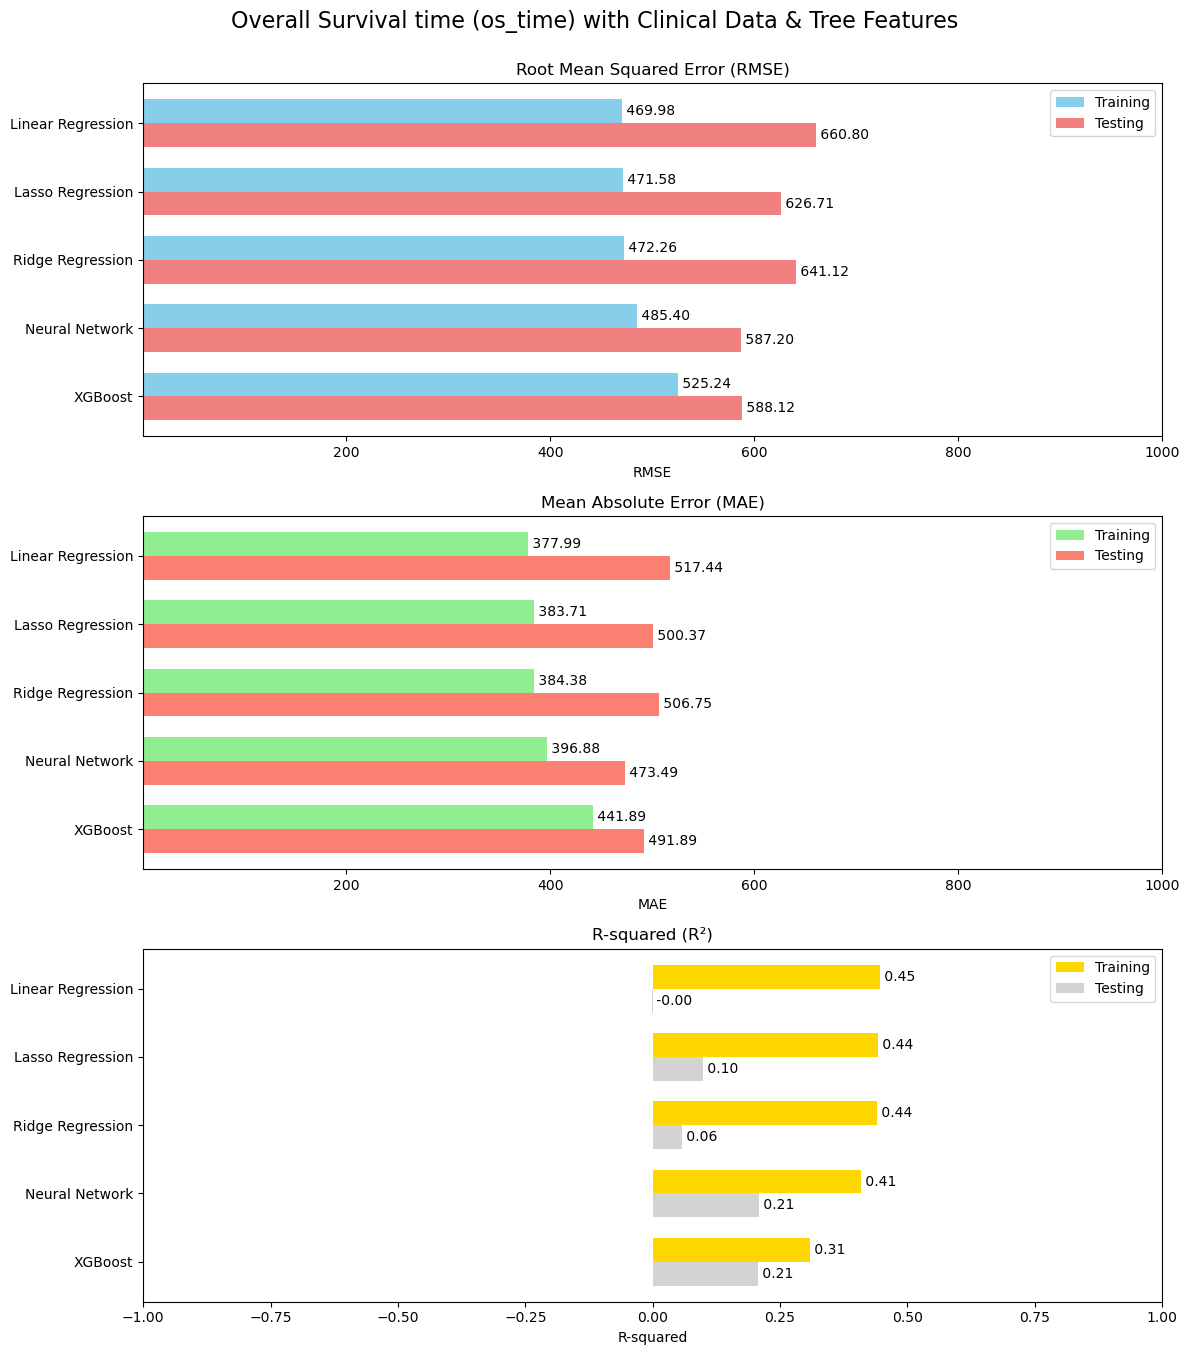

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming resultsdf_train_os and resultsdf_test_os are already defined and rounded
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Neural Network', 'XGBoost']
training_rmse = resultsdf_train_os['Root Mean Squared Error (RMSE)'].tolist()
testing_rmse = resultsdf_test_os['Root Mean Squared Error (RMSE)'].tolist()
training_mae = resultsdf_train_os['Mean Absolute Error (MAE)'].tolist()
testing_mae = resultsdf_test_os['Mean Absolute Error (MAE)'].tolist()
training_r_squared = resultsdf_train_os['Rsquared Error (R2)'].tolist()
testing_r_squared = resultsdf_test_os['Rsquared Error (R2)'].tolist()

# Create the plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
bar_height = 0.35
y_pos = np.arange(len(models))

# RMSE subplot
ax1.barh(y_pos, training_rmse, bar_height, label='Training', color='skyblue')
ax1.barh(y_pos + bar_height, testing_rmse, bar_height, label='Testing', color='lightcoral')
ax1.set_yticks(y_pos + bar_height / 2)
ax1.set_yticklabels(models)
ax1.invert_yaxis()
ax1.set_xlabel('RMSE')
ax1.set_title('Root Mean Squared Error (RMSE)')
ax1.legend()
ax1.set_xlim(1, 1000) 

# Annotate RMSE bars
for i, v in enumerate(training_rmse):
    ax1.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse):
    ax1.text(v, i + bar_height, f' {v:.2f}', va='center')

# MAE subplot
ax2.barh(y_pos, training_mae, bar_height, label='Training', color='lightgreen')
ax2.barh(y_pos + bar_height, testing_mae, bar_height, label='Testing', color='salmon')
ax2.set_yticks(y_pos + bar_height / 2)
ax2.set_yticklabels(models)
ax2.invert_yaxis()
ax2.set_xlabel('MAE')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.legend()
ax2.set_xlim(1, 1000) 


# Annotate MAE bars
for i, v in enumerate(training_mae):
    ax2.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae):
    ax2.text(v, i + bar_height, f' {v:.2f}', va='center')

# R-squared subplot
ax3.barh(y_pos, training_r_squared, bar_height, label='Training', color='gold')
ax3.barh(y_pos + bar_height, testing_r_squared, bar_height, label='Testing', color='lightgrey')
ax3.set_yticks(y_pos + bar_height / 2)
ax3.set_yticklabels(models)
ax3.invert_yaxis()
ax3.set_xlabel('R-squared')
ax3.set_title('R-squared (R²)')
ax3.legend()
ax3.set_xlim(-1, 1) 


# Annotate R-squared bars
for i, v in enumerate(training_r_squared):
    ax3.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared):
    ax3.text(v, i + bar_height, f' {v:.2f}', va='center')



# Title
# if ordinal_encoding:
#     fig.suptitle('Overall Survival time (os_time) with Ordinal Encoding', fontsize=16, y=0.9)

if clinicaldata_with_tree_features:
    fig.suptitle('Overall Survival time (os_time) with Clinical Data & Tree Features', fontsize=16, y=0.9)

# elif ordinal_encoding and include_tree_features:
#     fig.suptitle('Overall Survival time (os_time) with Ordinal Encoding and Tree featuers', fontsize=16, y=0.9)


elif only_tree_features:
    fig.suptitle('Overall Survival time (os_time) with Tree Featuers', fontsize=16, y=0.9)
else:
    fig.suptitle('Overall Survival time (os_time) with Clinical Data', fontsize=16, y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

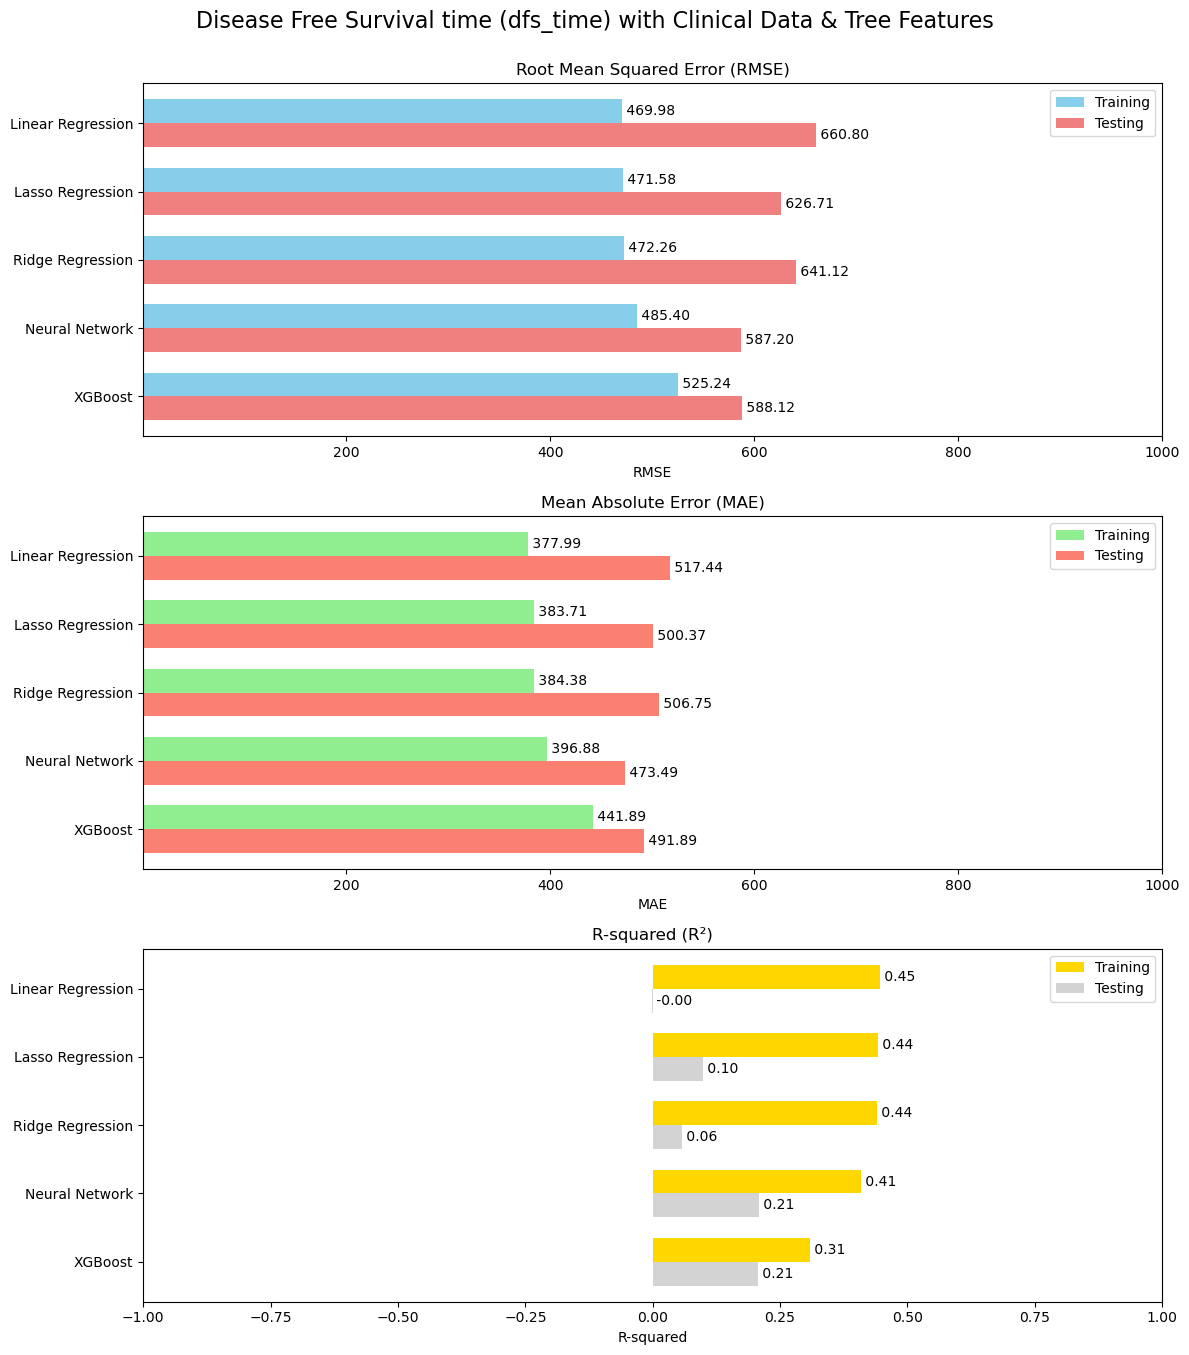

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming resultsdf_train_os and resultsdf_test_os are already defined and rounded
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Neural Network', 'XGBoost']
training_rmse_dfs = resultsdf_train_dfs['Root Mean Squared Error (RMSE)'].tolist()
testing_rmse_dfs = resultsdf_test_dfs['Root Mean Squared Error (RMSE)'].tolist()
training_mae_dfs = resultsdf_train_dfs['Mean Absolute Error (MAE)'].tolist()
testing_mae_dfs = resultsdf_test_dfs['Mean Absolute Error (MAE)'].tolist()
training_r_squared_dfs = resultsdf_train_dfs['Rsquared Error (R2)'].tolist()
testing_r_squared_dfs = resultsdf_test_dfs['Rsquared Error (R2)'].tolist()

# Create the plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
bar_height = 0.35
y_pos = np.arange(len(models))

# RMSE subplot
ax1.barh(y_pos, training_rmse, bar_height, label='Training', color='skyblue')
ax1.barh(y_pos + bar_height, testing_rmse, bar_height, label='Testing', color='lightcoral')
ax1.set_yticks(y_pos + bar_height / 2)
ax1.set_yticklabels(models)
ax1.invert_yaxis()
ax1.set_xlabel('RMSE')
ax1.set_title('Root Mean Squared Error (RMSE)')
ax1.legend()
ax1.set_xlim(1, 1000) 

# Annotate RMSE bars
for i, v in enumerate(training_rmse):
    ax1.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse):
    ax1.text(v, i + bar_height, f' {v:.2f}', va='center')

# MAE subplot
ax2.barh(y_pos, training_mae, bar_height, label='Training', color='lightgreen')
ax2.barh(y_pos + bar_height, testing_mae, bar_height, label='Testing', color='salmon')
ax2.set_yticks(y_pos + bar_height / 2)
ax2.set_yticklabels(models)
ax2.invert_yaxis()
ax2.set_xlabel('MAE')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.legend()
ax2.set_xlim(1, 1000) 


# Annotate MAE bars
for i, v in enumerate(training_mae):
    ax2.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae):
    ax2.text(v, i + bar_height, f' {v:.2f}', va='center')

# R-squared subplot
ax3.barh(y_pos, training_r_squared, bar_height, label='Training', color='gold')
ax3.barh(y_pos + bar_height, testing_r_squared, bar_height, label='Testing', color='lightgrey')
ax3.set_yticks(y_pos + bar_height / 2)
ax3.set_yticklabels(models)
ax3.invert_yaxis()
ax3.set_xlabel('R-squared')
ax3.set_title('R-squared (R²)')
ax3.legend()
ax3.set_xlim(-1, 1) 


# Annotate R-squared bars
for i, v in enumerate(training_r_squared):
    ax3.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared):
    ax3.text(v, i + bar_height, f' {v:.2f}', va='center')



# Title
# if ordinal_encoding:
#     fig.suptitle('Overall Survival time (os_time) with Ordinal Encoding', fontsize=16, y=0.9)

if clinicaldata_with_tree_features:
    fig.suptitle('Disease Free Survival time (dfs_time) with Clinical Data & Tree Features', fontsize=16, y=0.9)

# elif ordinal_encoding and include_tree_features:
#     fig.suptitle('Overall Survival time (os_time) with Ordinal Encoding and Tree featuers', fontsize=16, y=0.9)


elif only_tree_features:
    fig.suptitle(' Disease Free Survival time (dfs_time) with Tree Featuers', fontsize=16, y=0.9)
else:
    fig.suptitle('Disease Free Survival time (dfs_time) with Clinical Data', fontsize=16, y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

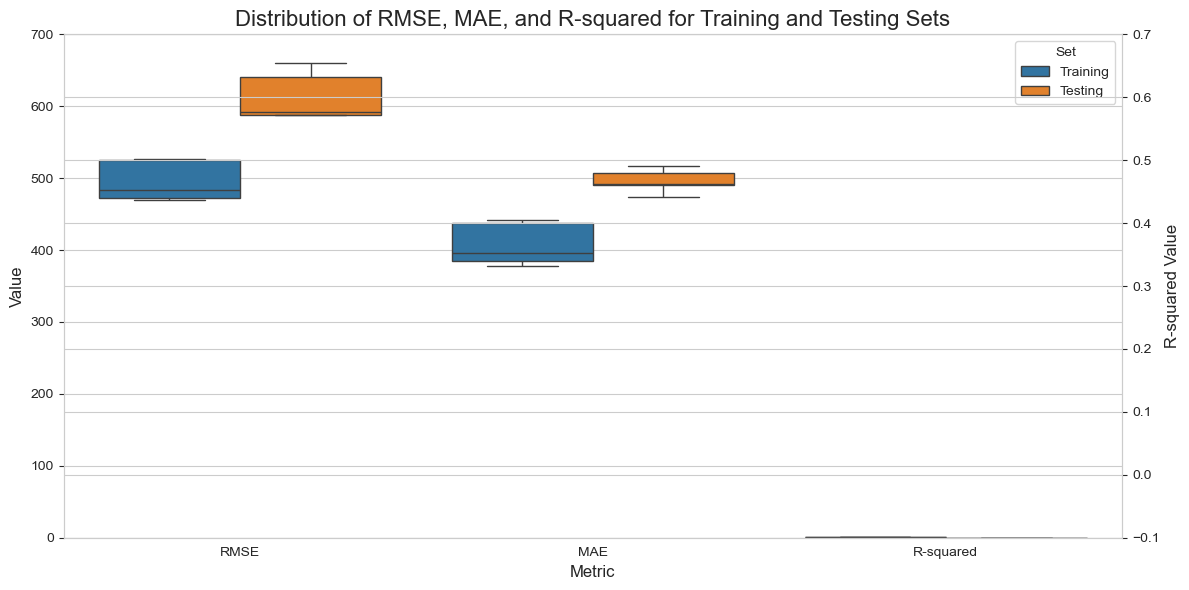

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'RMSE': {
        'Training': [469.9794, 527.1466, 472.2569, 483.7349853515625, 525.2398071289062],
        'Testing': [660.7966, 591.9548, 641.1175, 587.3865966796875, 588.123779296875]
    },
    'MAE': {
        'Training': [377.9921, 438.0939, 384.3771, 395.4580993652344, 441.8912048339844],
        'Testing': [517.4415, 491.1502, 506.7512, 473.6665954589844, 491.8893127441406]
    },
    'R-squared': {
        'Training': [0.4461505844568666, 0.3032, 0.4408, 0.4133, 0.3082],
        'Testing': [-0.0016, 0.1962, 0.0571, 0.2085, 0.2066]
    }
}

# Prepare data for seaborn
df = pd.DataFrame({
    'Metric': ['RMSE']*10 + ['MAE']*10 + ['R-squared']*10,
    'Set': ['Training']*5 + ['Testing']*5 + ['Training']*5 + ['Testing']*5 + ['Training']*5 + ['Testing']*5,
    'Value': data['RMSE']['Training'] + data['RMSE']['Testing'] + 
             data['MAE']['Training'] + data['MAE']['Testing'] + 
             data['R-squared']['Training'] + data['R-squared']['Testing']
})

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='Metric', y='Value', hue='Set', data=df)

# Customize the plot
plt.title('Distribution of RMSE, MAE, and R-squared for Training and Testing Sets', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Adjust y-axis for better visualization of R-squared
plt.ylim(-0.1, 700)

# Add a secondary y-axis for R-squared
ax2 = plt.twinx()
ax2.set_ylim(-0.1, 0.7)
ax2.set_ylabel('R-squared Value', fontsize=12)

plt.tight_layout()
plt.show()

In [90]:
timepass = [training_rmse,
testing_rmse,
training_mae,
testing_mae,
training_r_squared,
testing_r_squared,
training_rmse_dfs,
testing_rmse_dfs,
training_mae_dfs,
testing_mae_dfs,
training_r_squared_dfs,
testing_r_squared_dfs,]

timepass2 = ["training_rmse",
"testing_rmse",
"training_mae",
"testing_mae",
"training_r_squared",
"testing_r_squared",
"training_rmse_dfs",
"testing_rmse_dfs",
"training_mae_dfs",
"testing_mae_dfs",
"training_r_squared_dfs",
"testing_r_squared_dfs",]

for i,v in zip(timepass2,timepass):
    print(f"{i} = ", v)


training_rmse =  [469.9794, 471.5829, 472.2569, 485.3987121582031, 525.2398071289062]
testing_rmse =  [660.7966, 626.7076, 641.1175, 587.1956176757812, 588.123779296875]
training_mae =  [377.9921, 383.7107, 384.3771, 396.8771057128906, 441.8912048339844]
testing_mae =  [517.4415, 500.3715, 506.7512, 473.4888000488281, 491.8893127441406]
training_r_squared =  [0.4461505844568666, 0.4424, 0.4408, 0.4092, 0.3082]
testing_r_squared =  [-0.0016, 0.099, 0.0571, 0.2091, 0.2066]
training_rmse_dfs =  [498.9818, 500.6788, 501.1805, 509.0085144042969, 544.5443725585938]
testing_rmse_dfs =  [677.7537, 646.5792, 642.272, 604.4019775390625, 593.1356201171875]
training_mae_dfs =  [406.8112, 410.9595, 412.2466, 430.4012145996094, 467.04559326171875]
testing_mae_dfs =  [550.279, 537.1427, 535.4068, 509.90240478515625, 515.903076171875]
training_r_squared_dfs =  [0.4360466212931232, 0.4322, 0.4311, 0.4132, 0.3284]
testing_r_squared_dfs =  [-0.007, 0.0835, 0.0957, 0.1992, 0.2287]


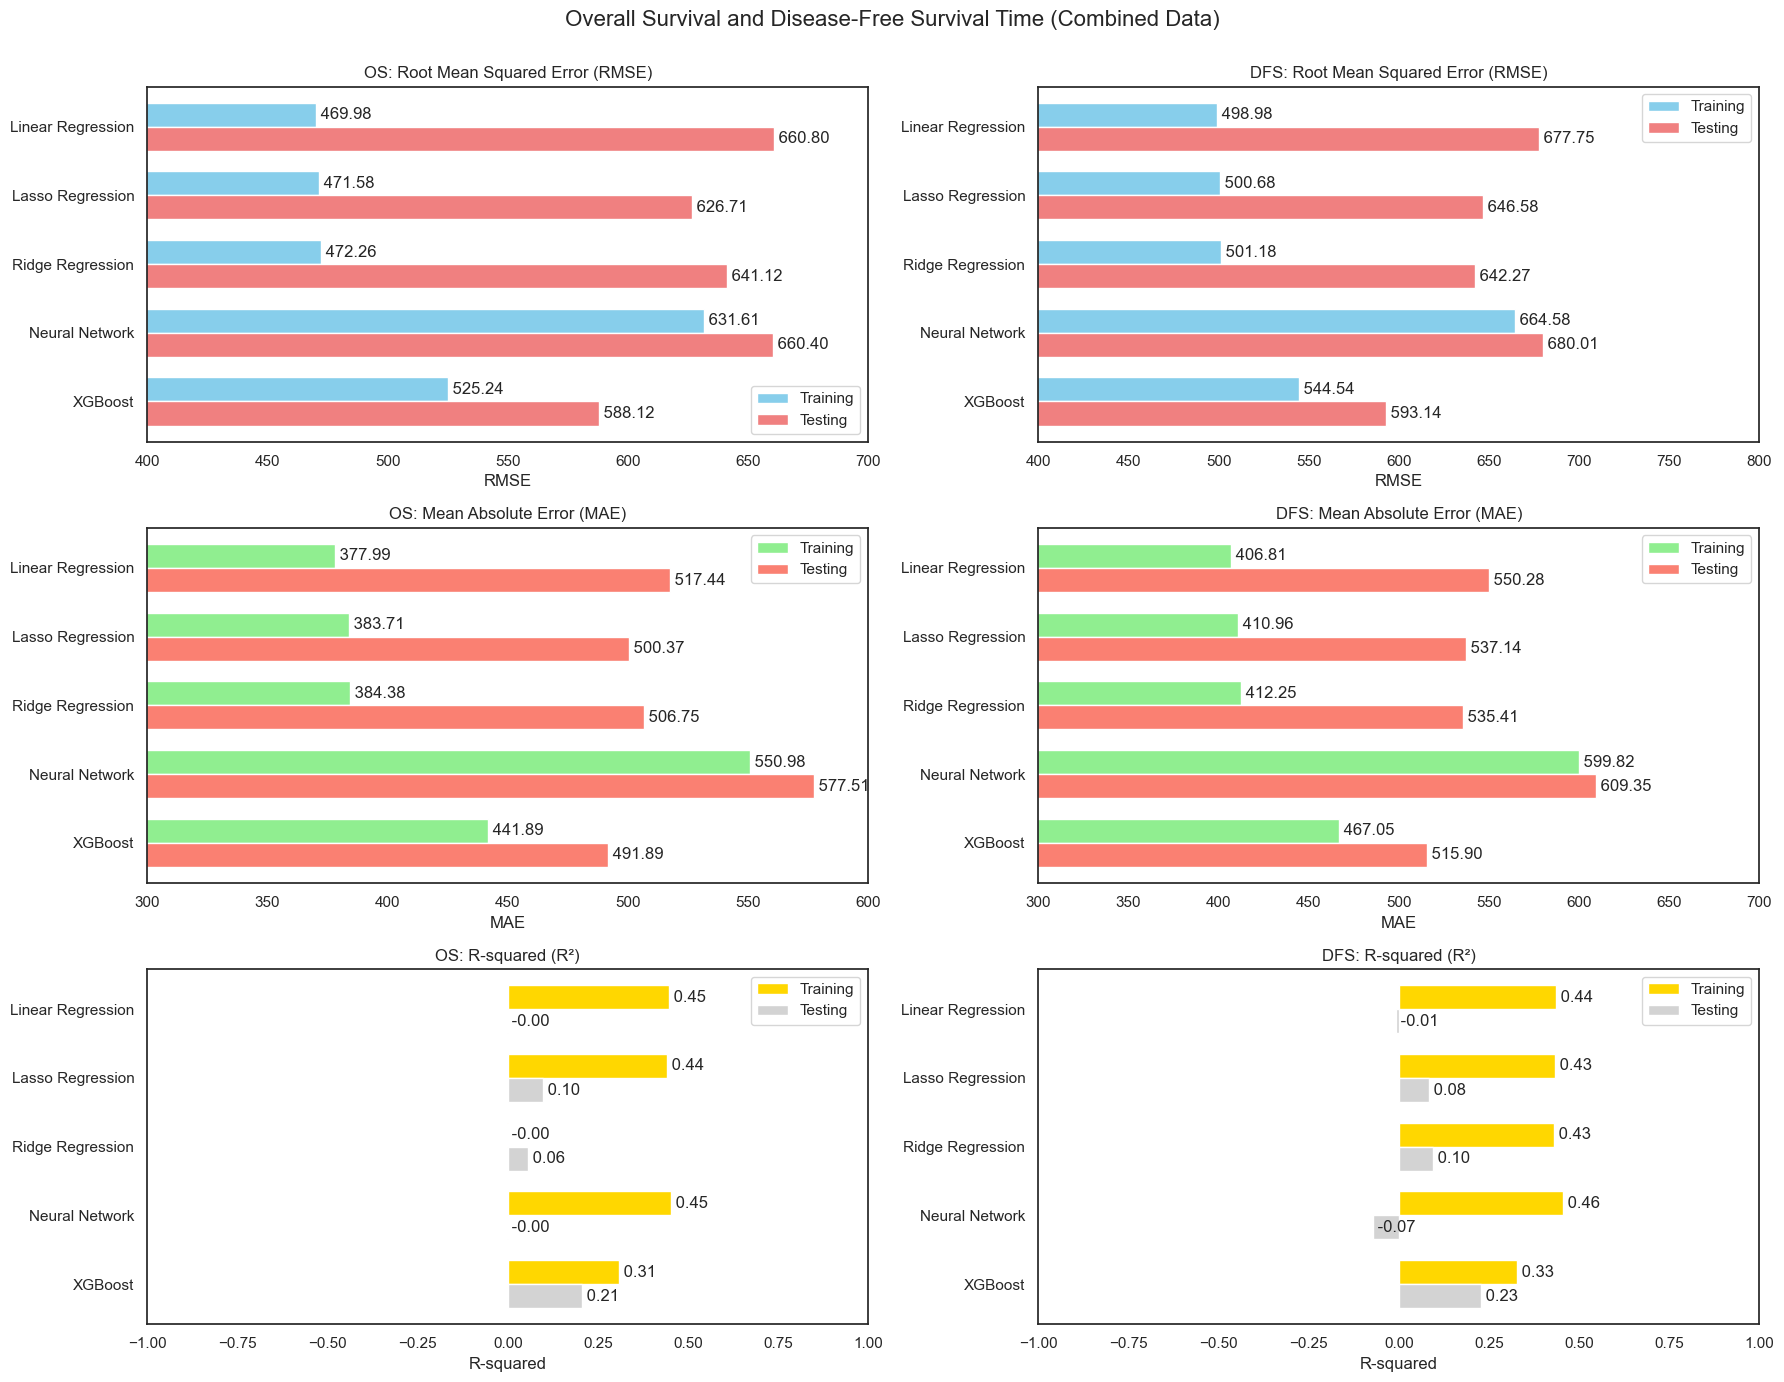

In [96]:

# Removing background grid properly
sns.set(style="white", rc={"axes.grid": False})  # Completely disable grid

# Recreate the plot with grid fully removed
fig, ((ax1_os, ax1_dfs), (ax2_os, ax2_dfs), (ax3_os, ax3_dfs)) = plt.subplots(3, 2, figsize=(18, 15))

# OS: RMSE subplot
ax1_os.barh(y_pos, training_rmse, bar_height, label='Training', color='skyblue')
ax1_os.barh(y_pos + bar_height, testing_rmse, bar_height, label='Testing', color='lightcoral')
ax1_os.set_yticks(y_pos + bar_height / 2)
ax1_os.set_yticklabels(models)
ax1_os.invert_yaxis()
ax1_os.set_xlabel('RMSE')
ax1_os.set_title('OS: Root Mean Squared Error (RMSE)')
ax1_os.legend()
ax1_os.set_xlim(400, 700)

# Annotate RMSE bars for OS
for i, v in enumerate(training_rmse):
    ax1_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse):
    ax1_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# OS: MAE subplot
ax2_os.barh(y_pos, training_mae, bar_height, label='Training', color='lightgreen')
ax2_os.barh(y_pos + bar_height, testing_mae, bar_height, label='Testing', color='salmon')
ax2_os.set_yticks(y_pos + bar_height / 2)
ax2_os.set_yticklabels(models)
ax2_os.invert_yaxis()
ax2_os.set_xlabel('MAE')
ax2_os.set_title('OS: Mean Absolute Error (MAE)')
ax2_os.legend()
ax2_os.set_xlim(300, 600)

# Annotate MAE bars for OS
for i, v in enumerate(training_mae):
    ax2_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae):
    ax2_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# OS: R-squared subplot
ax3_os.barh(y_pos, training_r_squared, bar_height, label='Training', color='gold')
ax3_os.barh(y_pos + bar_height, testing_r_squared, bar_height, label='Testing', color='lightgrey')
ax3_os.set_yticks(y_pos + bar_height / 2)
ax3_os.set_yticklabels(models)
ax3_os.invert_yaxis()
ax3_os.set_xlabel('R-squared')
ax3_os.set_title('OS: R-squared (R²)')
ax3_os.legend()
ax3_os.set_xlim(-1, 1)

# Annotate R-squared bars for OS
for i, v in enumerate(training_r_squared):
    ax3_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared):
    ax3_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: RMSE subplot
ax1_dfs.barh(y_pos, training_rmse_dfs, bar_height, label='Training', color='skyblue')
ax1_dfs.barh(y_pos + bar_height, testing_rmse_dfs, bar_height, label='Testing', color='lightcoral')
ax1_dfs.set_yticks(y_pos + bar_height / 2)
ax1_dfs.set_yticklabels(models)
ax1_dfs.invert_yaxis()
ax1_dfs.set_xlabel('RMSE')
ax1_dfs.set_title('DFS: Root Mean Squared Error (RMSE)')
ax1_dfs.legend()
ax1_dfs.set_xlim(400, 800)

# Annotate RMSE bars for DFS
for i, v in enumerate(training_rmse_dfs):
    ax1_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse_dfs):
    ax1_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: MAE subplot
ax2_dfs.barh(y_pos, training_mae_dfs, bar_height, label='Training', color='lightgreen')
ax2_dfs.barh(y_pos + bar_height, testing_mae_dfs, bar_height, label='Testing', color='salmon')
ax2_dfs.set_yticks(y_pos + bar_height / 2)
ax2_dfs.set_yticklabels(models)
ax2_dfs.invert_yaxis()
ax2_dfs.set_xlabel('MAE')
ax2_dfs.set_title('DFS: Mean Absolute Error (MAE)')
ax2_dfs.legend()
ax2_dfs.set_xlim(300, 700)

# Annotate MAE bars for DFS
for i, v in enumerate(training_mae_dfs):
    ax2_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae_dfs):
    ax2_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: R-squared subplot
ax3_dfs.barh(y_pos, training_r_squared_dfs, bar_height, label='Training', color='gold')
ax3_dfs.barh(y_pos + bar_height, testing_r_squared_dfs, bar_height, label='Testing', color='lightgrey')
ax3_dfs.set_yticks(y_pos + bar_height / 2)
ax3_dfs.set_yticklabels(models)
ax3_dfs.invert_yaxis()
ax3_dfs.set_xlabel('R-squared')
ax3_dfs.set_title('DFS: R-squared (R²)')
ax3_dfs.legend()
ax3_dfs.set_xlim(-1, 1)

# Annotate R-squared bars for DFS
for i, v in enumerate(training_r_squared_dfs):
    ax3_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared_dfs):
    ax3_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# Overall title
fig.suptitle('Overall Survival and Disease-Free Survival Time (Combined Data)', fontsize=16, y=0.92)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


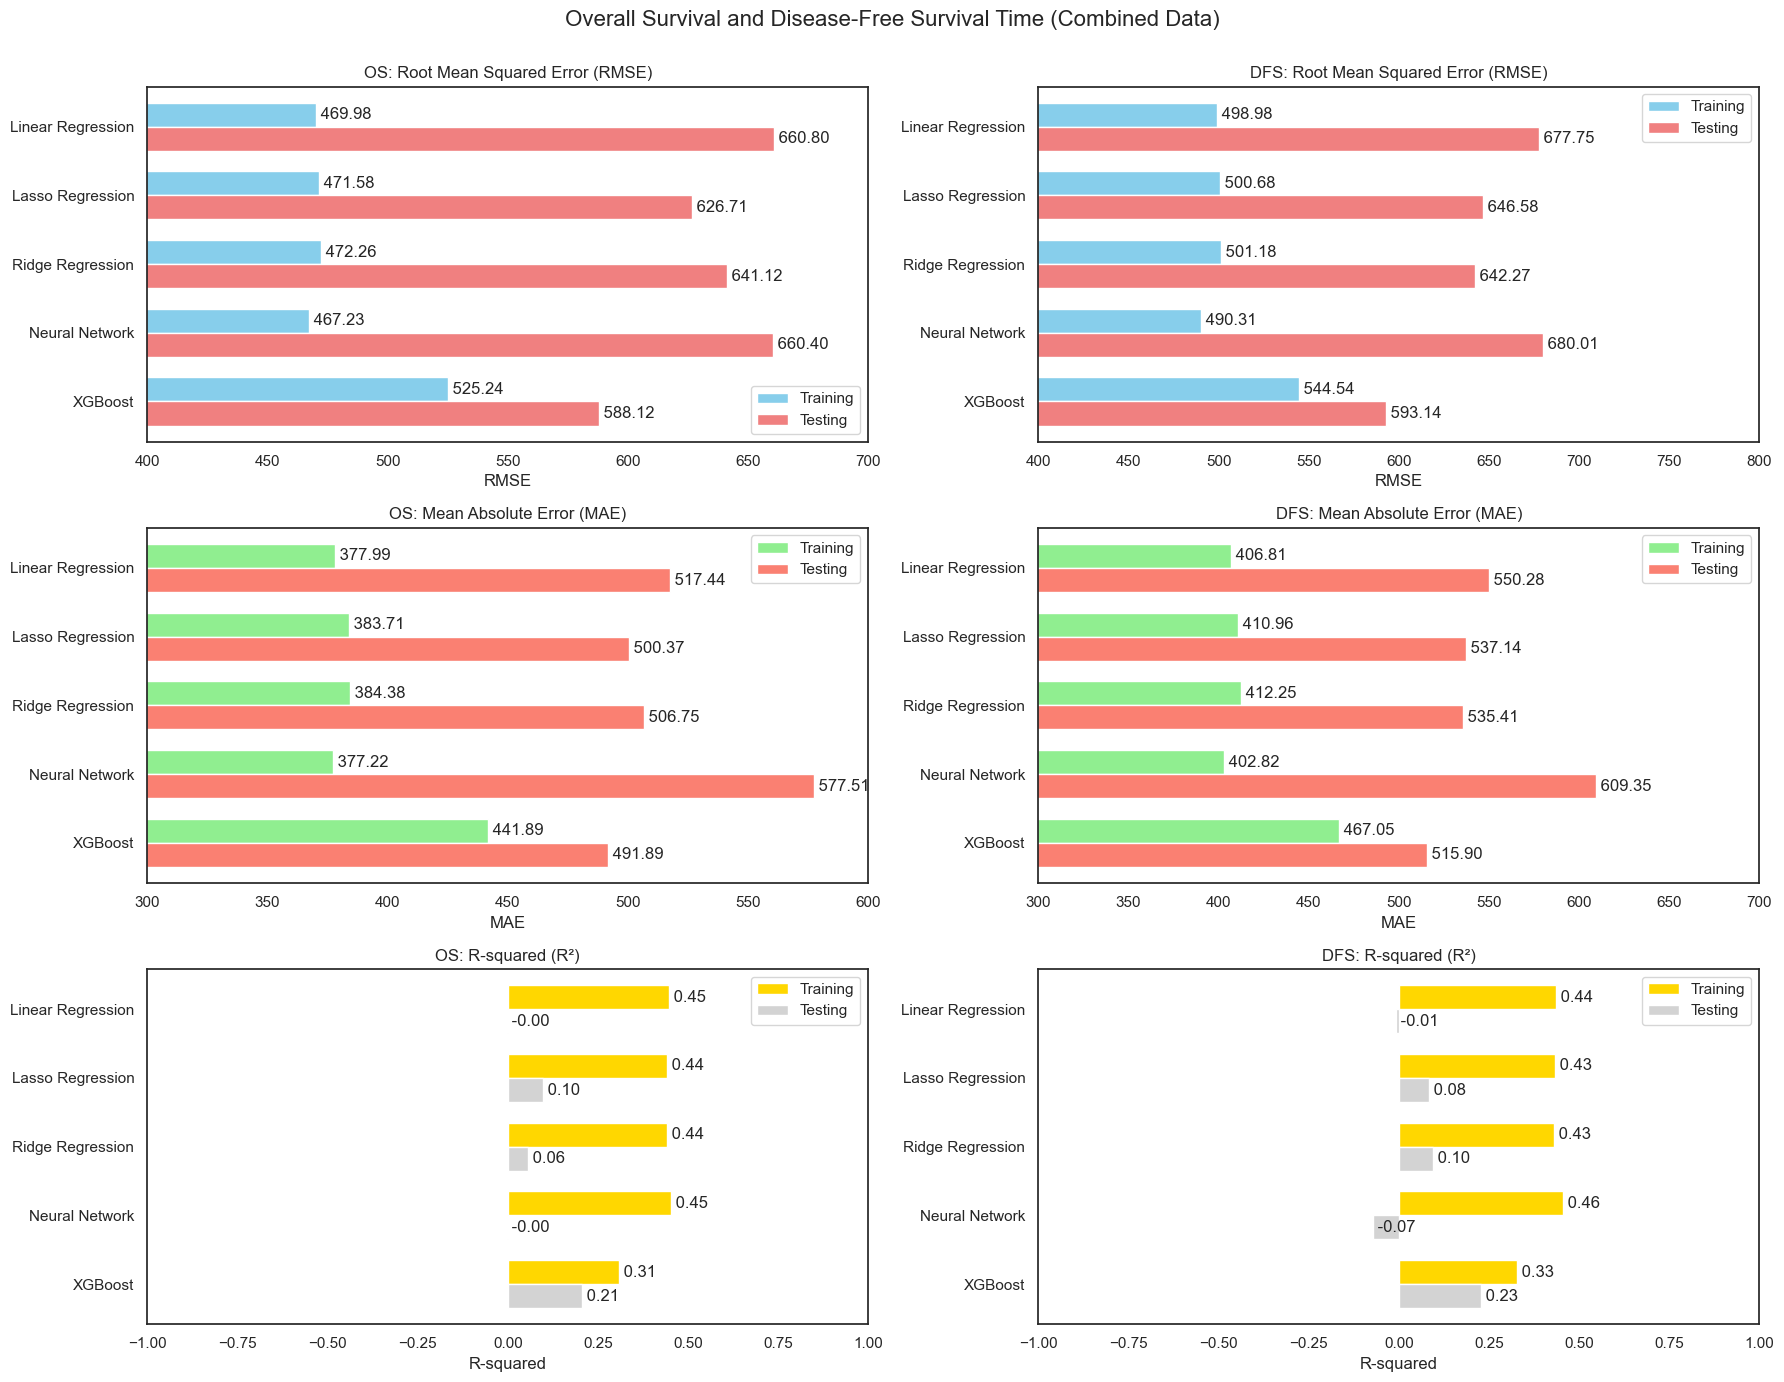

In [94]:

training_rmse =  [469.9794, 471.5829, 472.2569, 467.2318115234375, 525.2398071289062]
testing_rmse =  [660.7966, 626.7076, 641.1175, 660.40, 588.123779296875]
training_mae =  [377.9921, 383.7107, 384.3771, 377.224609375, 441.8912048339844]
testing_mae =  [517.4415, 500.3715, 506.7512, 577.51, 491.8893127441406]
training_r_squared =  [0.4461505844568666, 0.4424, 0.4408, 0.4526, 0.3082]
testing_r_squared =  [-0.0016, 0.099, 0.0571, -0.001, 0.2066]
training_rmse_dfs =  [498.9818, 500.6788, 501.1805, 490.31439208984375, 544.5443725585938]
testing_rmse_dfs =  [677.7537, 646.5792, 642.272, 680.01, 593.1356201171875]
training_mae_dfs =  [406.8112, 410.9595, 412.2466, 402.82159423828125, 467.04559326171875]
testing_mae_dfs =  [550.279, 537.1427, 535.4068, 609.35, 515.903076171875]
training_r_squared_dfs =  [0.4360466212931232, 0.4322, 0.4311, 0.4555, 0.3284]
testing_r_squared_dfs =  [-0.007, 0.0835, 0.0957, -0.07243, 0.2287]
# Removing background grid properly
sns.set(style="white", rc={"axes.grid": False})  # Completely disable grid

# Recreate the plot with grid fully removed
fig, ((ax1_os, ax1_dfs), (ax2_os, ax2_dfs), (ax3_os, ax3_dfs)) = plt.subplots(3, 2, figsize=(18, 15))

# OS: RMSE subplot
ax1_os.barh(y_pos, training_rmse, bar_height, label='Training', color='skyblue')
ax1_os.barh(y_pos + bar_height, testing_rmse, bar_height, label='Testing', color='lightcoral')
ax1_os.set_yticks(y_pos + bar_height / 2)
ax1_os.set_yticklabels(models)
ax1_os.invert_yaxis()
ax1_os.set_xlabel('RMSE')
ax1_os.set_title('OS: Root Mean Squared Error (RMSE)')
ax1_os.legend()
ax1_os.set_xlim(400, 700)

# Annotate RMSE bars for OS
for i, v in enumerate(training_rmse):
    ax1_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse):
    ax1_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# OS: MAE subplot
ax2_os.barh(y_pos, training_mae, bar_height, label='Training', color='lightgreen')
ax2_os.barh(y_pos + bar_height, testing_mae, bar_height, label='Testing', color='salmon')
ax2_os.set_yticks(y_pos + bar_height / 2)
ax2_os.set_yticklabels(models)
ax2_os.invert_yaxis()
ax2_os.set_xlabel('MAE')
ax2_os.set_title('OS: Mean Absolute Error (MAE)')
ax2_os.legend()
ax2_os.set_xlim(300, 600)

# Annotate MAE bars for OS
for i, v in enumerate(training_mae):
    ax2_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae):
    ax2_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# OS: R-squared subplot
ax3_os.barh(y_pos, training_r_squared, bar_height, label='Training', color='gold')
ax3_os.barh(y_pos + bar_height, testing_r_squared, bar_height, label='Testing', color='lightgrey')
ax3_os.set_yticks(y_pos + bar_height / 2)
ax3_os.set_yticklabels(models)
ax3_os.invert_yaxis()
ax3_os.set_xlabel('R-squared')
ax3_os.set_title('OS: R-squared (R²)')
ax3_os.legend()
ax3_os.set_xlim(-1, 1)

# Annotate R-squared bars for OS
for i, v in enumerate(training_r_squared):
    ax3_os.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared):
    ax3_os.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: RMSE subplot
ax1_dfs.barh(y_pos, training_rmse_dfs, bar_height, label='Training', color='skyblue')
ax1_dfs.barh(y_pos + bar_height, testing_rmse_dfs, bar_height, label='Testing', color='lightcoral')
ax1_dfs.set_yticks(y_pos + bar_height / 2)
ax1_dfs.set_yticklabels(models)
ax1_dfs.invert_yaxis()
ax1_dfs.set_xlabel('RMSE')
ax1_dfs.set_title('DFS: Root Mean Squared Error (RMSE)')
ax1_dfs.legend()
ax1_dfs.set_xlim(400, 800)

# Annotate RMSE bars for DFS
for i, v in enumerate(training_rmse_dfs):
    ax1_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_rmse_dfs):
    ax1_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: MAE subplot
ax2_dfs.barh(y_pos, training_mae_dfs, bar_height, label='Training', color='lightgreen')
ax2_dfs.barh(y_pos + bar_height, testing_mae_dfs, bar_height, label='Testing', color='salmon')
ax2_dfs.set_yticks(y_pos + bar_height / 2)
ax2_dfs.set_yticklabels(models)
ax2_dfs.invert_yaxis()
ax2_dfs.set_xlabel('MAE')
ax2_dfs.set_title('DFS: Mean Absolute Error (MAE)')
ax2_dfs.legend()
ax2_dfs.set_xlim(300, 700)

# Annotate MAE bars for DFS
for i, v in enumerate(training_mae_dfs):
    ax2_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_mae_dfs):
    ax2_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# DFS: R-squared subplot
ax3_dfs.barh(y_pos, training_r_squared_dfs, bar_height, label='Training', color='gold')
ax3_dfs.barh(y_pos + bar_height, testing_r_squared_dfs, bar_height, label='Testing', color='lightgrey')
ax3_dfs.set_yticks(y_pos + bar_height / 2)
ax3_dfs.set_yticklabels(models)
ax3_dfs.invert_yaxis()
ax3_dfs.set_xlabel('R-squared')
ax3_dfs.set_title('DFS: R-squared (R²)')
ax3_dfs.legend()
ax3_dfs.set_xlim(-1, 1)

# Annotate R-squared bars for DFS
for i, v in enumerate(training_r_squared_dfs):
    ax3_dfs.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(testing_r_squared_dfs):
    ax3_dfs.text(v, i + bar_height, f' {v:.2f}', va='center')

# Overall title
fig.suptitle('Overall Survival and Disease-Free Survival Time (Combined Data)', fontsize=16, y=0.92)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()



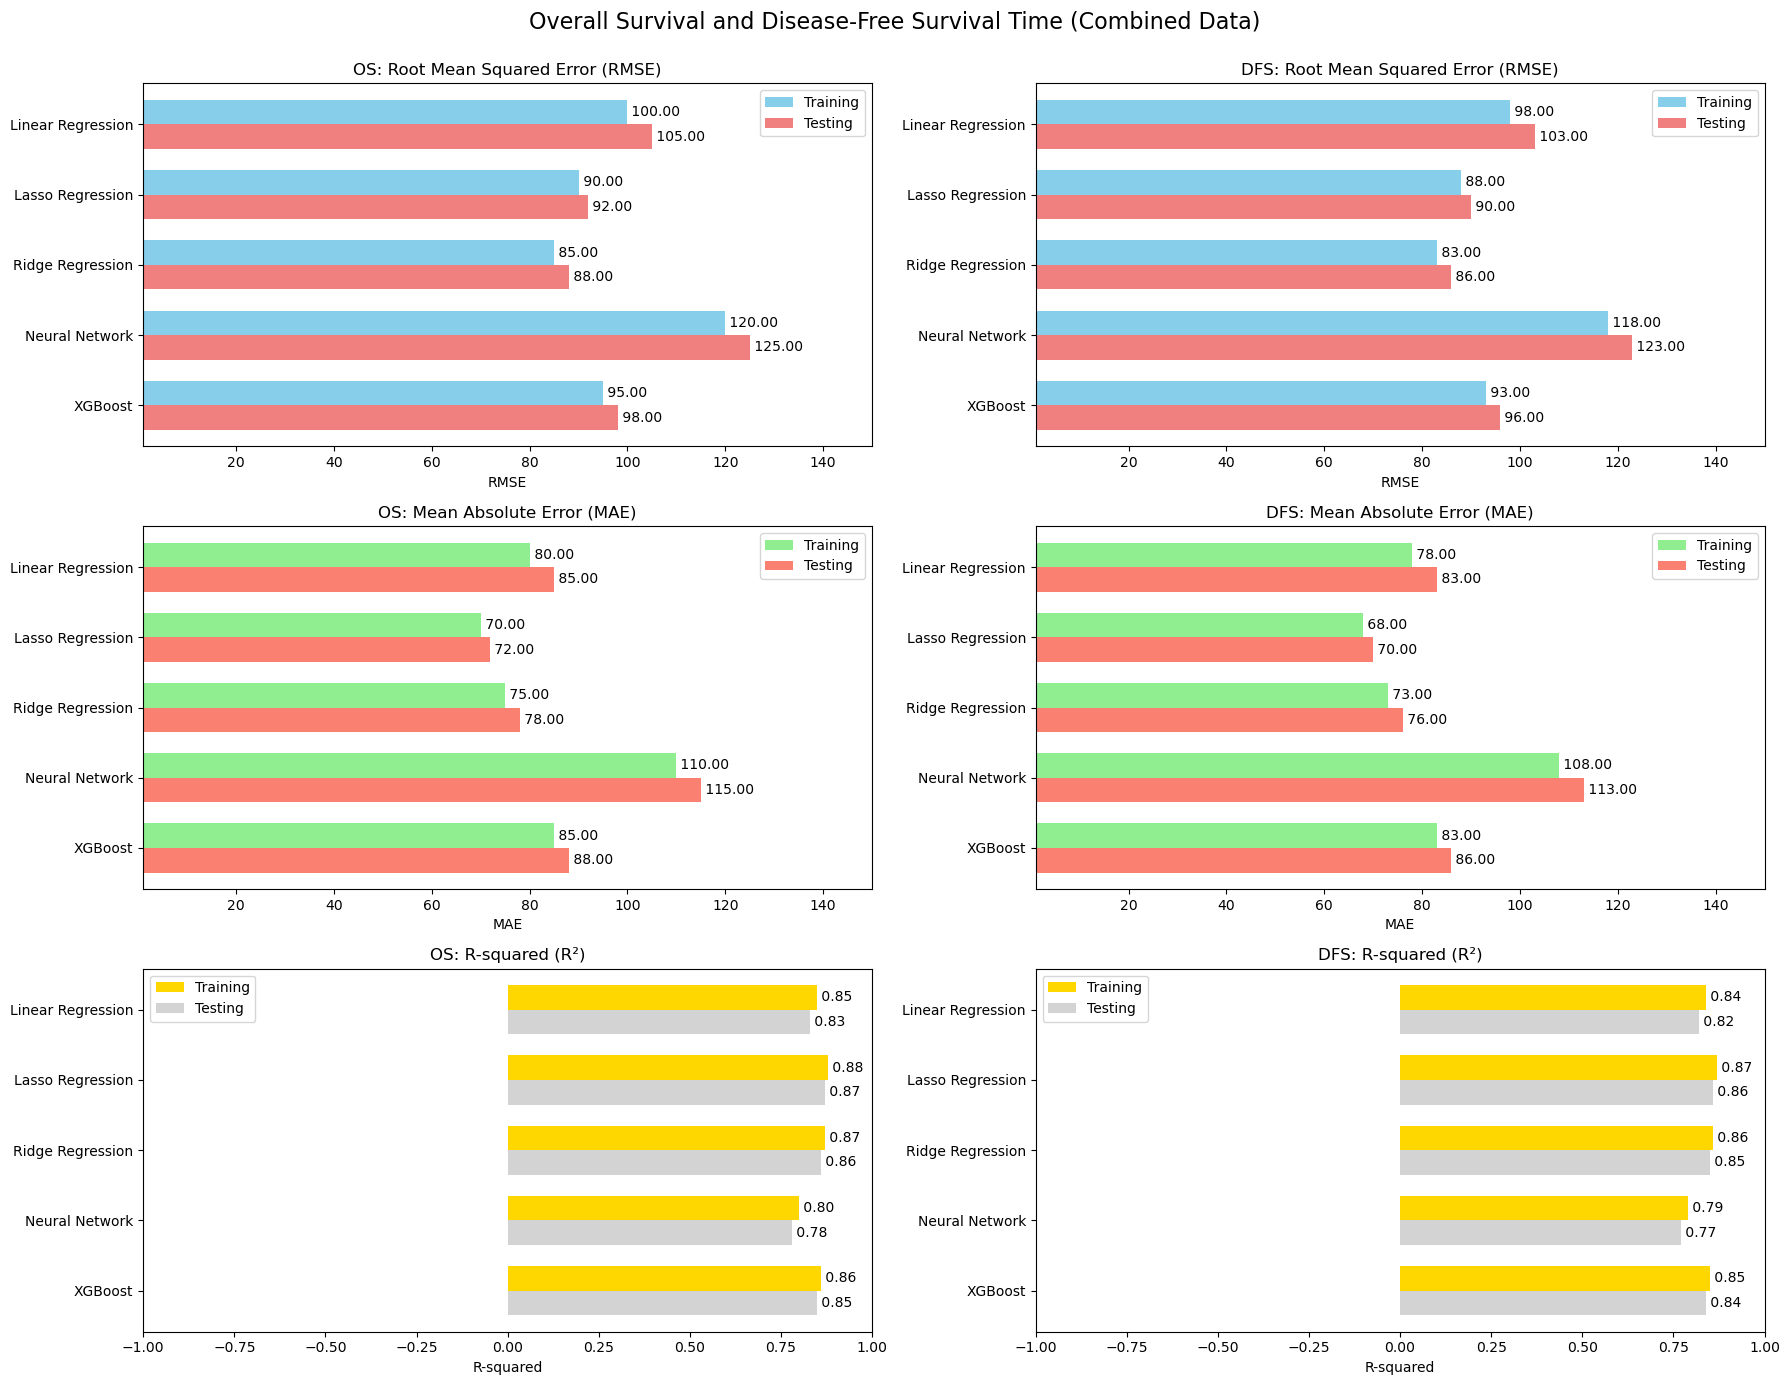

In [94]:
import pandas as pd

# Assuming you have these DataFrames already defined
# resultsdf_train_os, resultsdf_test_os, resultsdf_train_dfs, resultsdf_test_dfs

# Create an empty DataFrame to hold the combined results
combined_results = pd.DataFrame()

# Extract values for each model
for model_name in resultsdf_train_os.index:
    combined_results.loc[model_name, 'Train MSE (OS)'] = resultsdf_train_os.loc[model_name, 'Mean Squared Error (MSE)']
    combined_results.loc[model_name, 'Test MSE (OS)'] = resultsdf_test_os.loc[model_name, 'Mean Squared Error (MSE)']
    combined_results.loc[model_name, 'Train RMSE (OS)'] = resultsdf_train_os.loc[model_name, 'Root Mean Squared Error (RMSE)']
    combined_results.loc[model_name, 'Test RMSE (OS)'] = resultsdf_test_os.loc[model_name, 'Root Mean Squared Error (RMSE)']
    combined_results.loc[model_name, 'Train MAE (OS)'] = resultsdf_train_os.loc[model_name, 'Mean Absolute Error (MAE)']
    combined_results.loc[model_name, 'Test MAE (OS)'] = resultsdf_test_os.loc[model_name, 'Mean Absolute Error (MAE)']
    combined_results.loc[model_name, 'Train R2 (OS)'] = resultsdf_train_os.loc[model_name, 'Rsquared Error (R2)']
    combined_results.loc[model_name, 'Test R2 (OS)'] = resultsdf_test_os.loc[model_name, 'Rsquared Error (R2)']
    
    combined_results.loc[model_name, 'Train MSE (DFS)'] = resultsdf_train_dfs.loc[model_name, 'Mean Squared Error (MSE)']
    combined_results.loc[model_name, 'Test MSE (DFS)'] = resultsdf_test_dfs.loc[model_name, 'Mean Squared Error (MSE)']
    combined_results.loc[model_name, 'Train RMSE (DFS)'] = resultsdf_train_dfs.loc[model_name, 'Root Mean Squared Error (RMSE)']
    combined_results.loc[model_name, 'Test RMSE (DFS)'] = resultsdf_test_dfs.loc[model_name, 'Root Mean Squared Error (RMSE)']
    combined_results.loc[model_name, 'Train MAE (DFS)'] = resultsdf_train_dfs.loc[model_name, 'Mean Absolute Error (MAE)']
    combined_results.loc[model_name, 'Test MAE (DFS)'] = resultsdf_test_dfs.loc[model_name, 'Mean Absolute Error (MAE)']
    combined_results.loc[model_name, 'Train R2 (DFS)'] = resultsdf_train_dfs.loc[model_name, 'Rsquared Error (R2)']
    combined_results.loc[model_name, 'Test R2 (DFS)'] = resultsdf_test_dfs.loc[model_name, 'Rsquared Error (R2)']

# Display the combined results
if only_tree_features:
    
    combined_results.to_csv('only_tree_results.csv')

elif clinicaldata_with_tree_features:
    combined_results.to_csv('clinicaldata_tree_results.csv')

else:
    print('here')
    combined_results.to_csv('clini.csv')

here


In [154]:
final_df1 = pd.read_csv('clini.csv')
final_df2 = pd.read_csv('only_tree_results.csv')
final_df3 = pd.read_csv('clinicaldata_tree_results.csv')


combined_results = final_df3

In [155]:
# Print the combined results in a structured format
for model_name in combined_results.index[4:]:
    print(f"Model: {model_name}")
    print(f"  Train MSE (OS): {combined_results.loc[model_name, 'Train MSE (OS)']:.4e}")
    print(f"  Test MSE (OS): {combined_results.loc[model_name, 'Test MSE (OS)']:.4e}")
    print(f"  Train RMSE (OS): {combined_results.loc[model_name, 'Train RMSE (OS)']:.4e}")
    print(f"  Test RMSE (OS): {combined_results.loc[model_name, 'Test RMSE (OS)']:.4e}")
    print(f"  Train MAE (OS): {combined_results.loc[model_name, 'Train MAE (OS)']:.4e}")
    print(f"  Test MAE (OS): {combined_results.loc[model_name, 'Test MAE (OS)']:.4e}")
    print(f"  Train R2 (OS): {combined_results.loc[model_name, 'Train R2 (OS)']:.4f}")
    print(f"  Test R2 (OS): {combined_results.loc[model_name, 'Test R2 (OS)']:.4f}")
    print(f"  Train MSE (DFS): {combined_results.loc[model_name, 'Train MSE (DFS)']:.4e}")
    print(f"  Test MSE (DFS): {combined_results.loc[model_name, 'Test MSE (DFS)']:.4e}")
    print(f"  Train RMSE (DFS): {combined_results.loc[model_name, 'Train RMSE (DFS)']:.4e}")
    print(f"  Test RMSE (DFS): {combined_results.loc[model_name, 'Test RMSE (DFS)']:.4e}")
    print(f"  Train MAE (DFS): {combined_results.loc[model_name, 'Train MAE (DFS)']:.4e}")
    print(f"  Test MAE (DFS): {combined_results.loc[model_name, 'Test MAE (DFS)']:.4e}")
    print(f"  Train R2 (DFS): {combined_results.loc[model_name, 'Train R2 (DFS)']:.4f}")
    print(f"  Test R2 (DFS): {combined_results.loc[model_name, 'Test R2 (DFS)']:.4f}")
    print("\n")

Model: 4
  Train MSE (OS): 2.7588e+05
  Test MSE (OS): 3.4589e+05
  Train RMSE (OS): 5.2524e+02
  Test RMSE (OS): 5.8812e+02
  Train MAE (OS): 4.4189e+02
  Test MAE (OS): 4.9189e+02
  Train R2 (OS): 0.3082
  Test R2 (OS): 0.2066
  Train MSE (DFS): 2.9653e+05
  Test MSE (DFS): 3.5181e+05
  Train RMSE (DFS): 5.4454e+02
  Test RMSE (DFS): 5.9314e+02
  Train MAE (DFS): 4.6705e+02
  Test MAE (DFS): 5.1590e+02
  Train R2 (DFS): 0.3284
  Test R2 (DFS): 0.2287




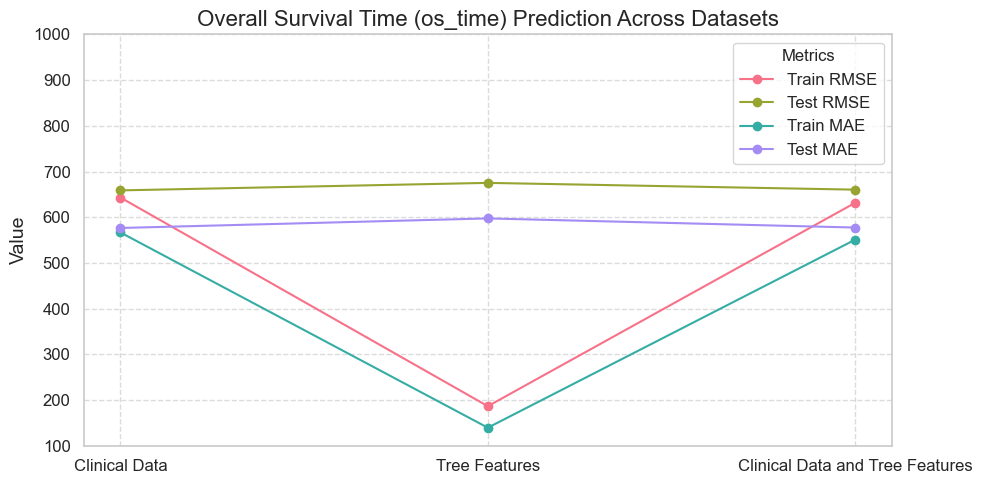

Neural Network


In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframes
final_df1 = pd.read_csv('clini.csv')
final_df2 = pd.read_csv('only_tree_results.csv')
final_df3 = pd.read_csv('clinicaldata_tree_results.csv')

# Extract relevant values for linear regression (first index)
metrics = ['Train RMSE (OS)', 'Test RMSE (OS)', 'Train MAE (OS)', 'Test MAE (OS)']
values_df1 = final_df1.loc[3, metrics]
values_df2 = final_df2.loc[3, metrics]
values_df3 = final_df3.loc[3, metrics]

# Remove (OS) from metric names for plotting
clean_metrics = [metric.replace(' (OS)', '') for metric in metrics]

# Combine the values into a single dataframe for plotting
combined_df = pd.DataFrame({
    'Metric': metrics * 3,
    'Value': list(values_df1) + list(values_df2) + list(values_df3),
    'Dataset': ['Clinical Data'] * 4 + ['Tree Features'] * 4 + ['Clinical Data and Tree Features'] * 4
})

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(metrics))

# Plotting
plt.figure(figsize=(10, 5))
for i, metric in enumerate(metrics):
    subset = combined_df[combined_df['Metric'] == metric]
    plt.plot(subset['Dataset'], subset['Value'], marker='o', label=clean_metrics[i], color=palette[i])

plt.title('Overall Survival Time (os_time) Prediction Across Datasets', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(100,1000)
plt.tight_layout()
plt.savefig(f'{final_df1.loc[3].values[0]}_OS.png')
plt.show()

print(final_df1.loc[3].values[0])


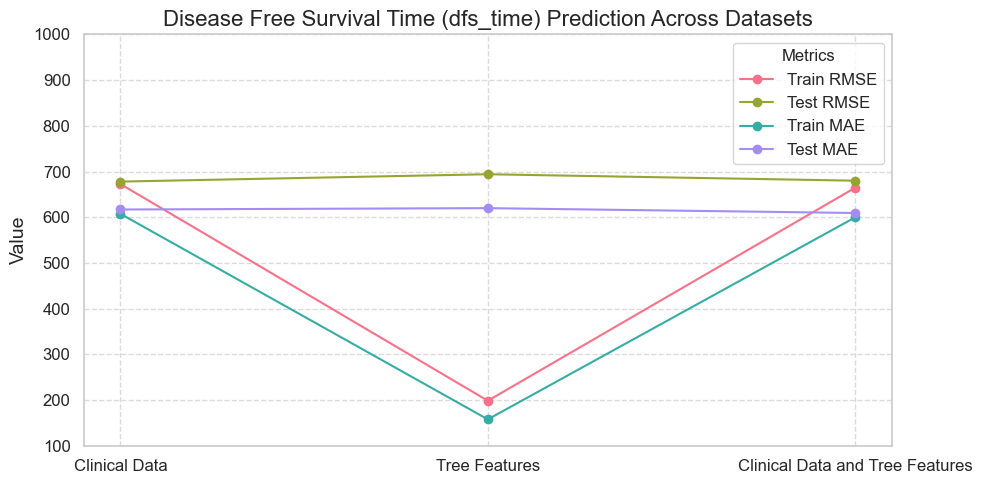

Neural Network


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframes
final_df1 = pd.read_csv('clini.csv')
final_df2 = pd.read_csv('only_tree_results.csv')
final_df3 = pd.read_csv('clinicaldata_tree_results.csv')

# Extract relevant values for lin3ar regression (first index)
metrics = ['Train RMSE (DFS)', 'Test RMSE (DFS)', 'Train MAE (DFS)', 'Test MAE (DFS)']

values_df1 = final_df1.loc[4, metrics]
values_df2 = final_df2.loc[4, metrics]
values_df3 = final_df3.loc[4, metrics]

# Remove (OS) from metric names for plotting
clean_metrics = [metric.replace(' (DFS)', '') for metric in metrics]

# Combine the values into a single dataframe for plotting
combined_df = pd.DataFrame({
    'Metric': metrics * 3,
    'Value': list(values_df1) + list(values_df2) + list(values_df3),
    'Dataset': ['Clinical Data'] * 4 + ['Tree Features'] * 4 + ['Clinical Data and Tree Features'] * 4
})

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(metrics))

# Plotting
plt.figure(figsize=(10, 5))
for i, metric in enumerate(metrics):
    subset = combined_df[combined_df['Metric'] == metric]
    plt.plot(subset['Dataset'], subset['Value'], marker='o', label=clean_metrics[i], color=palette[i])

plt.title('Disease Free Survival Time (dfs_time) Prediction Across Datasets', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(100,1000)
plt.tight_layout()
plt.savefig(f'{final_df1.loc[4].values[0]}_DFS.png')

plt.show()
print(final_df1.loc[4].values[0])

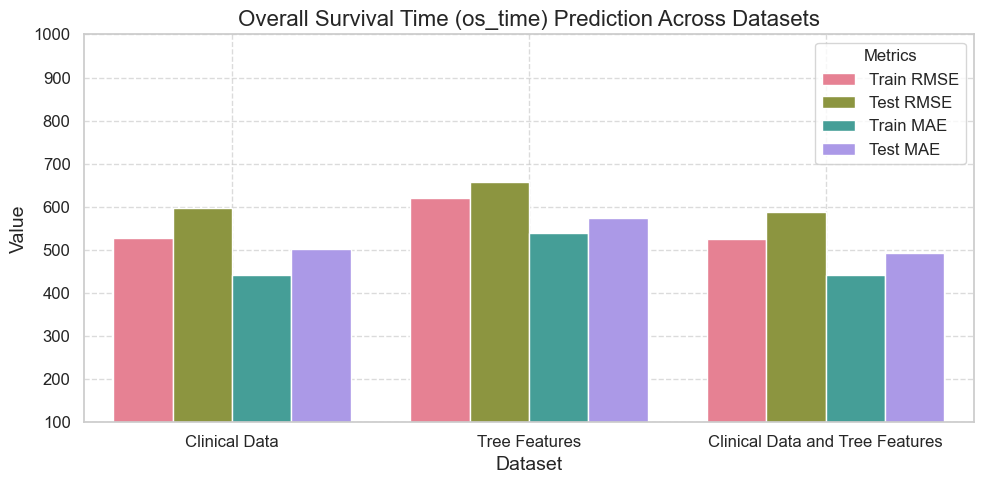

XGBoost


In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframes
final_df1 = pd.read_csv('clini.csv')
final_df2 = pd.read_csv('only_tree_results.csv')
final_df3 = pd.read_csv('clinicaldata_tree_results.csv')

# Extract relevant values for linear regression (first index)
metrics = ['Train RMSE (OS)', 'Test RMSE (OS)', 'Train MAE (OS)', 'Test MAE (OS)']
values_df1 = final_df1.loc[4, metrics]
values_df2 = final_df2.loc[4, metrics]
values_df3 = final_df3.loc[4, metrics]

# Remove (OS) from metric names for plotting
clean_metrics = [metric.replace(' (OS)', '') for metric in metrics]

# Combine the values into a single dataframe for plotting
combined_df = pd.DataFrame({
    'Metric': clean_metrics * 3,  # Remove (OS) for cleaner labels
    'Value': list(values_df1) + list(values_df2) + list(values_df3),
    'Dataset': ['Clinical Data'] * 4 + ['Tree Features'] * 4 + ['Clinical Data and Tree Features'] * 4
})

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(metrics))

# Plotting a bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Dataset', y='Value', hue='Metric', data=combined_df, palette=palette)

# Customize the plot
plt.title('Overall Survival Time (os_time) Prediction Across Datasets', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(100, 1000)
plt.tight_layout()

# Save the plot
plt.savefig(f'{final_df1.loc[4].values[0]}_OS_bar.png')
plt.show()

# Print the saved file name for confirmatio4
print(final_df1.loc[4].values[0])

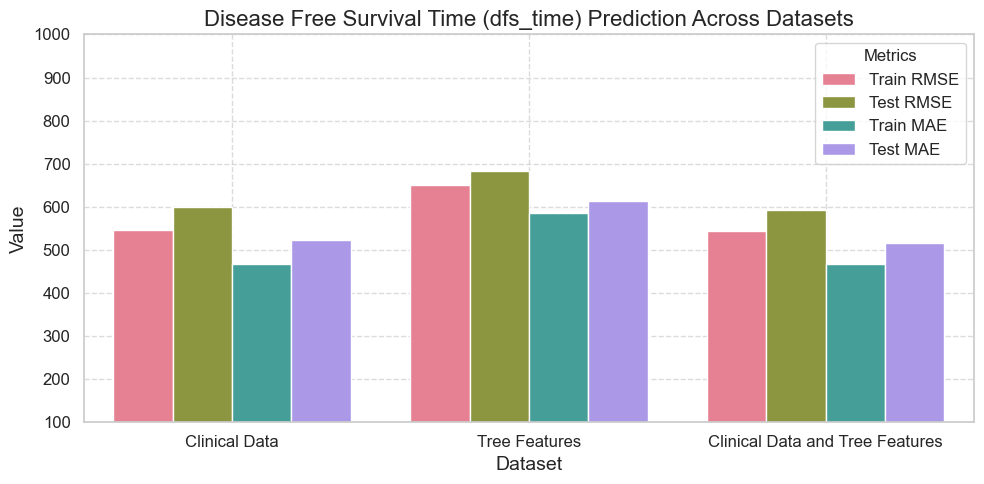

XGBoost


In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframes
final_df1 = pd.read_csv('clini.csv')
final_df2 = pd.read_csv('only_tree_results.csv')
final_df3 = pd.read_csv('clinicaldata_tree_results.csv')

# Extract relevant values for linear regression (first index)
metrics = ['Train RMSE (DFS)', 'Test RMSE (DFS)', 'Train MAE (DFS)', 'Test MAE (DFS)']
values_df1 = final_df1.loc[4, metrics]
values_df2 = final_df2.loc[4, metrics]
values_df3 = final_df3.loc[4, metrics]

# Remove (OS) from metric names for plotting
clean_metrics = [metric.replace(' (DFS)', '') for metric in metrics]

# Combine the values into a single dataframe for plotting
combined_df = pd.DataFrame({
    'Metric': clean_metrics * 3,  # Remove (OS) for cleaner labels
    'Value': list(values_df1) + list(values_df2) + list(values_df3),
    'Dataset': ['Clinical Data'] * 4 + ['Tree Features'] * 4 + ['Clinical Data and Tree Features'] * 4
})

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(metrics))

# Plotting a bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Dataset', y='Value', hue='Metric', data=combined_df, palette=palette)

# Customize the plot
plt.title('Disease Free Survival Time (dfs_time) Prediction Across Datasets', fontsize=16)
plt.ylabel('Value', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(100, 1000)
plt.tight_layout()

# Save the plot
plt.savefig(f'{final_df1.loc[3].values[0]}_DFS_bar.png')
plt.show()

# Print the saved file name for confirmation
print(final_df1.loc[4].values[0])

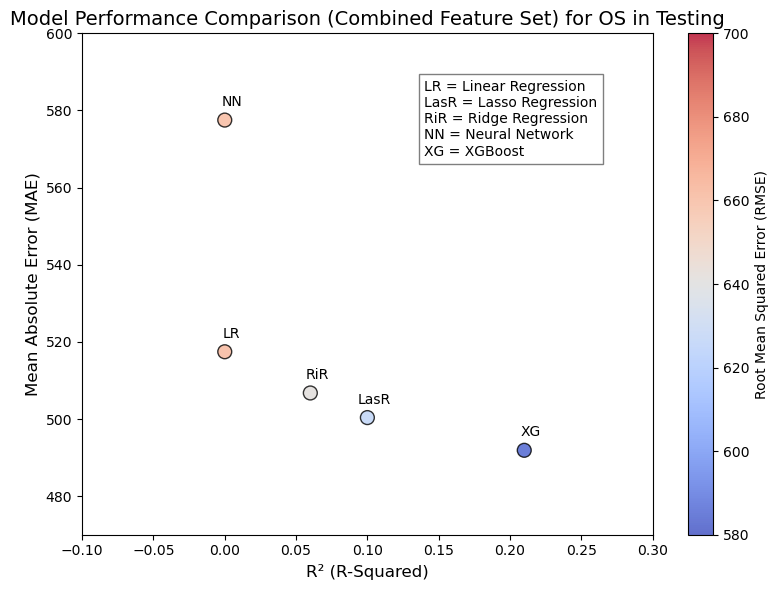

In [263]:
# Adjust the scale of the scatter plot to ensure points are placed properly based on the metrics

# Define the plot again with better scaling
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with RMSE as the color, MAE on the y-axis, and R² on the x-axis
scatter = ax.scatter(r2_combined, mae_combined, s=100, c=rmse_combined, cmap='coolwarm', edgecolor='k', alpha=0.8, vmin=580, vmax=700)

# Annotate each model, positioning labels slightly above points
for i, model in enumerate(models):
    ax.annotate(model, (r2_combined[i], mae_combined[i]), textcoords="offset points", xytext=(5,10), ha='center')

# Add colorbar for RMSE values
cbar = plt.colorbar(scatter)
cbar.set_label('Root Mean Squared Error (RMSE)')

# Set labels and title with proper scaling
ax.set_xlabel('R² (R-Squared)', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_title('Model Performance Comparison (Combined Feature Set) for OS in Testing', fontsize=14)

# Adjust x and y axis limits for better spacing and representation
ax.set_xlim(-0.1, 0.3)
ax.set_ylim(470, 600)

# Add note for abbreviations with proper placement
ax.text(0.6, 0.75, 'LR = Linear Regression\nLasR = Lasso Regression\nRiR = Ridge Regression\nNN = Neural Network\nXG = XGBoost', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# Display the plot
plt.tight_layout()
plt.show()


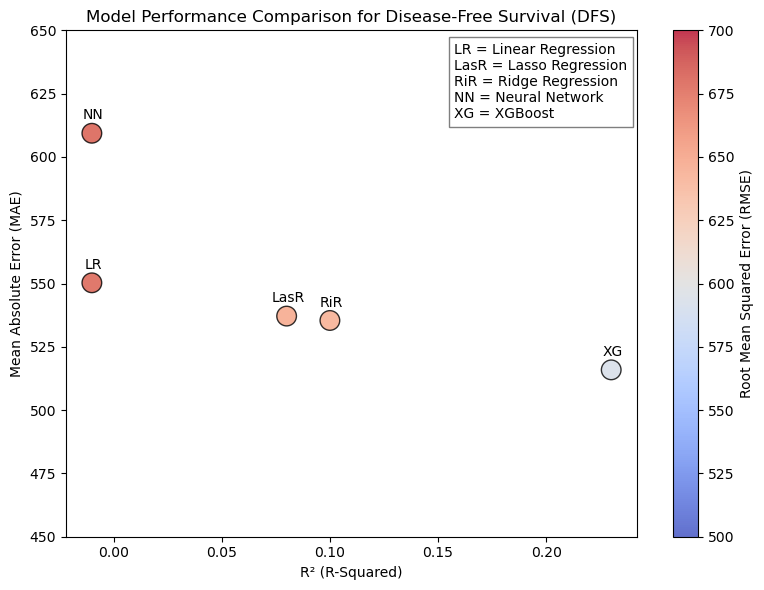

In [258]:

# Data for scatter plot (for DFS prediction)
models_dfs = ["LR", "LasR", "RiR", "NN", "XG"]
mse_combined_dfs = [459350, 418060, 412510, 462410, 351810]  # MSE for each model
r2_combined_dfs = [-0.01, 0.08, 0.10, -0.01, 0.23]  # R² for each model
rmse_combined_dfs = [677.75, 646.58, 642.27, 680.01, 593.14]  # RMSE for each model
mae_combined_dfs = [550.28, 537.14, 535.41, 609.35, 515.90]  # MAE for each model

# Scatter points for each model with a note for abbreviations

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with RMSE as color and MAE vs R²
scatter_dfs = ax.scatter(r2_combined_dfs, mae_combined_dfs, s=200, c=rmse_combined_dfs, cmap='coolwarm', edgecolor='k', alpha=0.8, vmin=500, vmax=700)

# Annotate each model
for i, model in enumerate(models_dfs):
    ax.annotate(model, (r2_combined_dfs[i], mae_combined_dfs[i]), textcoords="offset points", xytext=(1,10), ha='center')

# Add colorbar for RMSE values
cbar_dfs = plt.colorbar(scatter_dfs)
cbar_dfs.set_label('Root Mean Squared Error (RMSE)')

# Labels and title
ax.set_xlabel('R² (R-Squared)')
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('Model Performance Comparison for Disease-Free Survival (DFS)')
ax.set_ylim(450, 650)

# Add note for abbreviations
ax.text(0.68, 0.82, 'LR = Linear Regression\nLasR = Lasso Regression\nRiR = Ridge Regression\nNN = Neural Network\nXG = XGBoost', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# Show plot
plt.tight_layout()
plt.show()

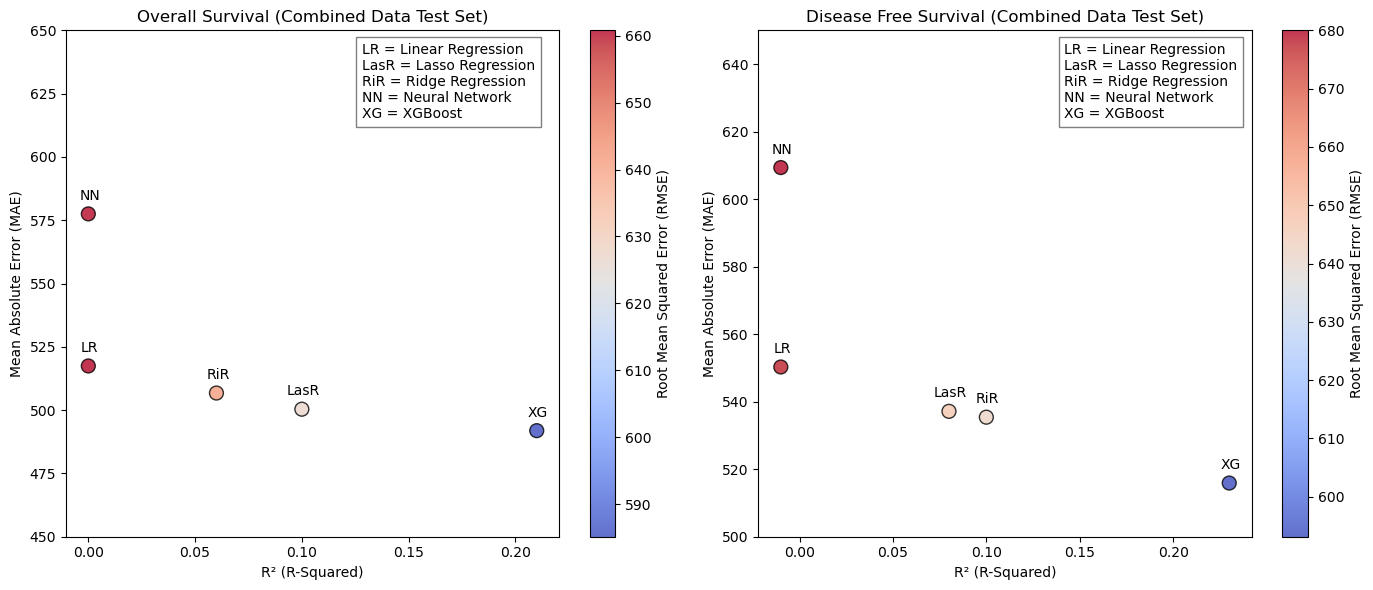

In [252]:
# Combined plot for OS and DFS model performance as subplots side by side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# OS Performance (subplot 1)
scatter_os = ax1.scatter(r2_combined, mae_combined, s=100, c=rmse_combined, cmap='coolwarm', edgecolor='k', alpha=0.8)
for i, model in enumerate(models):
    ax1.annotate(model, (r2_combined[i], mae_combined[i]), textcoords="offset points", xytext=(1,10), ha='center')
cbar_os = plt.colorbar(scatter_os, ax=ax1)
cbar_os.set_label('Root Mean Squared Error (RMSE)')
ax1.set_xlabel('R² (R-Squared)')
ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_title('Overall Survival (Combined Data Test Set)')
ax1.set_ylim(450, 650)

# Add note for abbreviations for OS
ax1.text(0.6, 0.82, 'LR = Linear Regression\nLasR = Lasso Regression\nRiR = Ridge Regression\nNN = Neural Network\nXG = XGBoost', 
        transform=ax1.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# DFS Performance (subplot 2)
scatter_dfs = ax2.scatter(r2_combined_dfs, mae_combined_dfs, s=100, c=rmse_combined_dfs, cmap='coolwarm', edgecolor='k', alpha=0.8)
for i, model in enumerate(models_dfs):
    ax2.annotate(model, (r2_combined_dfs[i], mae_combined_dfs[i]), textcoords="offset points", xytext=(1,10), ha='center')
cbar_dfs = plt.colorbar(scatter_dfs, ax=ax2)
cbar_dfs.set_label('Root Mean Squared Error (RMSE)')
ax2.set_xlabel('R² (R-Squared)')
ax2.set_ylabel('Mean Absolute Error (MAE)')
ax2.set_title('Disease Free Survival (Combined Data Test Set)')
ax2.set_ylim(500, 650)

# Add note for abbreviations for DFS
ax2.text(0.62, 0.82, 'LR = Linear Regression\nLasR = Lasso Regression\nRiR = Ridge Regression\nNN = Neural Network\nXG = XGBoost', 
        transform=ax2.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [5]:
from smolagents import DuckDuckGoSearchTool




In [ ]:
tool = DuckDuckGoSearchTool()
tool.